# PRÁCTICA 1 - Estimación de modelos factoriales de valoración de activos

### Autores: Gonzalo Moll Acha y Guillem Borràs Espert

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import warnings
import textwrap

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from adjustText import adjust_text
from utils import (plot, 
                   ajusta_modelo,
                   to_pct,
                   calcular_aic_cartera,
                   estimar_beta,
                   analiza_cartera_w,
                   ajusta_barra_mcg,
                   analiza_cartera_barra, 
                   pesos_longshort,
                   grafico_contrib)
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


###  Leemos excel y procedemos al análisis descriptivo de los datos

In [40]:
#Leemos excel
prices_df = pd.read_excel("Clean_Data_100.xlsx")

#Eliminamos fila con ticker, trabajaremos con nombres de las empresas
prices_df = prices_df[prices_df.iloc[:, 0] != "CODE"]
#Convertir fechas a formato datetime y establecer como índice temporal 
#el df de precios
prices_df.iloc[:, 0] = pd.to_datetime(prices_df.iloc[:, 0], errors='coerce')
prices_df.set_index(prices_df.columns[0], inplace=True)
prices_df.index.name = "Date"

prices_df = prices_df.apply(pd.to_numeric, errors='coerce')

In [41]:
# Leer la hoja "Carac" sin encabezado automático
carac_df = pd.read_excel("Clean_Data_100.xlsx", sheet_name="Carac", header=None)

# Tomar la primera fila como nombres de columnas
carac_df.columns = carac_df.iloc[0]     # primera fila = nombres de columnas
carac_df = carac_df.drop(0)             # eliminar esa primera fila del cuerpo
carac_df = carac_df.reset_index(drop=True)

# Transponer: las filas se vuelven columnas (manteniendo solo los datos)
caracT_df = carac_df.set_index(carac_df.columns[0]).T

# Quitar cualquier nombre residual de columnas
caracT_df.columns.name = None

print(carac_df.shape, "→", caracT_df.shape)
display(caracT_df)

(100, 22) → (21, 100)


,ROLLS-ROYCE HOLDINGS,LLOYDS BANKING GROUP,TESCO,LEGAL & GENERAL,VODAFONE GROUP,RELX,ENEL,INTESA SANPAOLO,COMPASS GROUP,GLENCORE,...,CHRISTIAN DIOR,LVMH,KERING,LONZA GROUP,DNB BANK,EQUINOR,ZURICH INSURANCE GROUP,INVESTOR B,DSV,GIVAUDAN 'N'
0,,,,,,,,,,,,,,,,,,,,,
CODE,RR.(P),LLOY(P),TSCO(P),LGEN(P),VOD(P),REL(P),I:ENEL(P),I:ISP(P),CPG(P),GLEN(P),...,F:CDI(P),F:LVMH(P),F:KER(P),S:LONN(P),N:DNB(P),N:EQNR(P),S:ZURN(P),W:ISBF(P),DK:DSV(P),S:GIVN(P)
DATASTREAM INDEX,TOTMKUK,TOTMKUK,TOTMKUK,TOTMKUK,TOTMKUK,TOTMKUK,TOTMKIT,TOTMKIT,TOTMKUK,TOTMKUK,...,TOTMKFR,TOTMKFR,TOTMKFR,TOTMKSW,TOTMKNW,TOTMKNW,TOTMKSW,TOTMKSD,TOTMKDK,TOTMKSW
COMPANY NAME,ROLLS ROYCE HOLDINGS PLC,LLOYDS BANKING GROUP PLC,TESCO PLC,LEGAL & GENERAL GROUP PLC,VODAFONE GROUP PUBLIC LIMITED COMPANY,RELX PLC,ENEL SPA,INTESA SANPAOLO SPA,COMPASS GROUP PLC,GLENCORE PLC,...,CHRISTIAN DIOR SE,LVMH MOET HENNESSY LOUIS VUITTON SE,KERING SA,LONZA GROUP AG,DNB BANK ASA,EQUINOR ASA,ZURICH INSURANCE GROUP LIMITED,INVESTOR AB,DSV A/S,GIVAUDAN SA
BUSINESS DESCRIPT - EXTENDED,Rolls Royce Holdings Plc. Rolls-Royce Holdings...,Lloyds Banking Group plc is a United Kingdom-b...,Tesco PLC is a United Kingdom-based retail com...,Legal & General Group Plc is a United Kingdom-...,Vodafone Group public limited company. Vodafon...,RELX PLC is a United Kingdom-based global prov...,Enel SpA is an Italy-based multinational power...,Intesa Sanpaolo S.p.A. is an Italy-based banki...,Compass Group PLC is a United Kingdom-based no...,Glencore PLC is a Switzerland-based producer a...,...,Christian Dior SE is a France-based holding co...,LVMH Moet Hennessy Louis Vuitton SE is a Franc...,Kering SA is a France-based luxury group. The ...,Lonza Group AG (Lonza) is a Switzerland-based ...,DNB BANK ASA is a Norway-based financial servi...,"Equinor ASA, formerly Volue AS is a Norway-bas...",Zurich Insurance Group AG is a holding company...,Investor AB is a Sweden-based industrial holdi...,Dsv A/S Formerly known as DSV Panalpina A/S. D...,Givaudan SA is a Switzerland-based company eng...
INDUSTRY GROUP,98,102,88,106,142,84,169,102,256,122,...,69,69,69,157,102,97,141,113,64,33
IND. GROUP MNEM,AEROS,BANKS,FDRET,LFINS,TELSV,PUBLS,CNVEL,BANKS,VENDC,MINES,...,CLTHG,CLTHG,CLTHG,BIOTC,BANKS,OILIN,FLINS,DIVFS,TRNSV,CHMSP
COUNTRY OF DOMICIL,UK,UK,UK,UK,UK,UK,IT,IT,UK,SW,...,FR,FR,FR,SW,NW,NW,SW,SD,DK,SW
CTRY OF DOM -NAME,UNITED KINGDOM,UNITED KINGDOM,UNITED KINGDOM,UNITED KINGDOM,UNITED KINGDOM,UNITED KINGDOM,ITALY,ITALY,UNITED KINGDOM,SWITZERLAND,...,FRANCE,FRANCE,FRANCE,SWITZERLAND,NORWAY,NORWAY,SWITZERLAND,SWEDEN,DENMARK,SWITZERLAND
MARKET VAL BY CO.,25670.92,27121.8,20879.17,14751.63,18316.05,61829.08,67730.38,50378.22,37079.49,50303.52,...,115254.3,331050.6,43258.96,26920.47,328268,894323.9,63547.68,703935.2,269369.9,30906.2


Como vamos a trabajar con rendimientos, directamente pasamos a rendimientos logarítmicos

In [42]:
#Creamos dataframe de rendimientos
ret_df = np.log(prices_df).diff().dropna()
ret_df.describe()

,3I GROUP,LVMH,NOVO NORDISK 'B',ASML HOLDING,NESTLE 'N',NOVARTIS 'R',L'OREAL,SSAB B,ASTRAZENECA,ROCHE HOLDING,...,THALES,ASSA ABLOY B,FERROVIAL,HEXAGON B,KONINKLIJKE AHOLD DELHAIZE,LEGAL & GENERAL,LONZA GROUP,NATURGY ENERGY,NATWEST GROUP,PRUDENTIAL
count,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,...,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000
mean,0.000832,0.000464,0.000509,0.000930,0.000102,0.000239,0.000445,0.000142,0.000376,0.000162,...,0.000650,0.000531,0.000567,0.000579,0.000388,0.000245,0.000641,0.000231,0.000466,0.000220
std,0.017077,0.016847,0.018134,0.019935,0.009729,0.011353,0.013694,0.023680,0.014491,0.011960,...,0.016116,0.014739,0.014724,0.018348,0.012627,0.018284,0.017718,0.015202,0.027119,0.019833
min,-0.151865,-0.090777,-0.262763,-0.170123,-0.070740,-0.102988,-0.078829,-0.151763,-0.167374,-0.090184,...,-0.119474,-0.102703,-0.133284,-0.125899,-0.100198,-0.226427,-0.196495,-0.182553,-0.198995,-0.182553
25%,-0.007240,-0.008433,-0.007966,-0.009167,-0.004750,-0.005283,-0.006970,-0.012205,-0.006507,-0.005861,...,-0.007107,-0.007062,-0.006764,-0.008222,-0.005646,-0.007038,-0.007710,-0.006675,-0.010375,-0.009178
50%,0.000789,0.000305,0.000000,0.000841,0.000000,0.000000,0.000275,0.000000,0.000133,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000519,0.000367,0.000410,0.000480,0.000275,0.000000
75%,0.009655,0.009150,0.009662,0.011537,0.005304,0.006157,0.007701,0.012504,0.007666,0.006666,...,0.008630,0.008145,0.008448,0.009479,0.006989,0.008276,0.009613,0.007810,0.011256,0.009776
max,0.157180,0.120552,0.159243,0.130633,0.060341,0.074311,0.081003,0.160442,0.134312,0.063395,...,0.148807,0.079965,0.127674,0.105361,0.077183,0.154061,0.134240,0.143951,0.980783,0.164372


In [43]:
# Asimetría (skewness)
skewness = ret_df.skew(axis=0, skipna=True)

# Curtosis (kurtosis de Fisher → 0 = normal)
kurtosis = ret_df.kurt(axis=0, skipna=True)

# Un resumen junto con la media y desviación típica
summary = pd.DataFrame({
    'mean': ret_df.mean(),
    'std': ret_df.std(),
    'skewness': skewness,
    'kurtosis': kurtosis
})

print(summary.head())

                      mean       std  skewness   kurtosis
3I GROUP          0.000832  0.017077 -0.344251   7.475467
LVMH              0.000464  0.016847  0.150596   3.586417
NOVO NORDISK 'B'  0.000509  0.018134 -1.708645  26.182030
ASML HOLDING      0.000930  0.019935 -0.240661   5.271180
NESTLE 'N'        0.000102  0.009729 -0.424887   4.864625


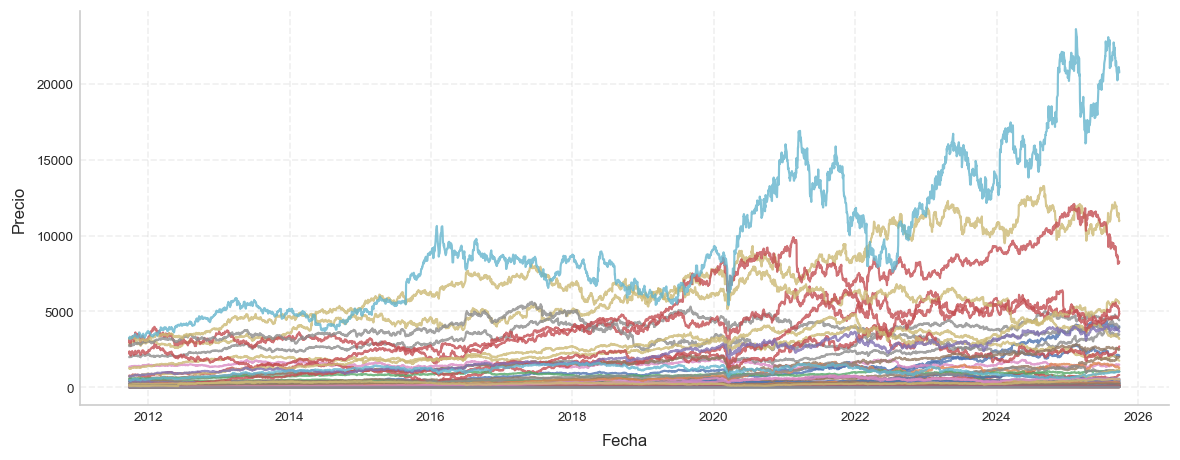

In [44]:
plot(prices_df, activos='All')

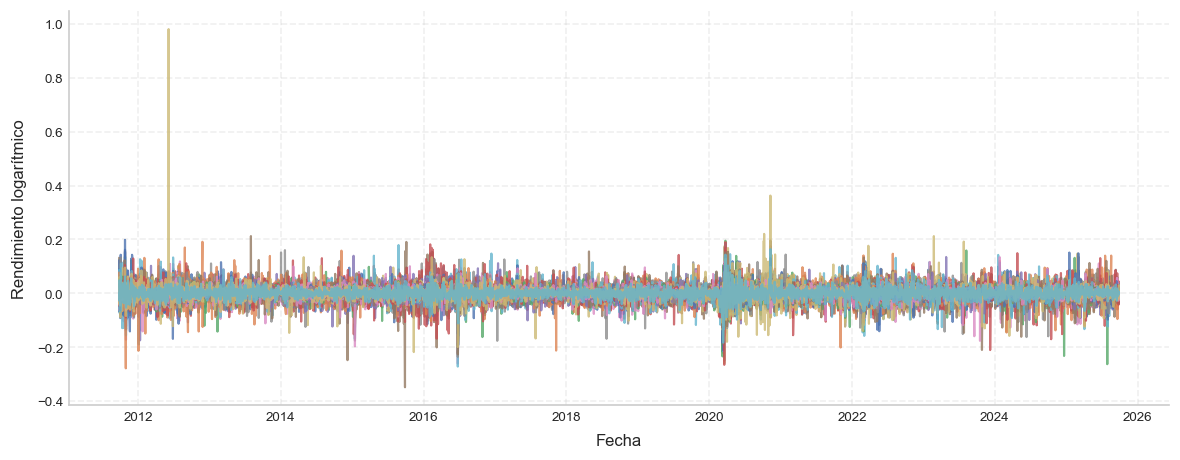

In [45]:
plot(ret_df, activos='All', stock=False)

In [46]:
corr_matrix = ret_df.corr()
display(corr_matrix)

,3I GROUP,LVMH,NOVO NORDISK 'B',ASML HOLDING,NESTLE 'N',NOVARTIS 'R',L'OREAL,SSAB B,ASTRAZENECA,ROCHE HOLDING,...,THALES,ASSA ABLOY B,FERROVIAL,HEXAGON B,KONINKLIJKE AHOLD DELHAIZE,LEGAL & GENERAL,LONZA GROUP,NATURGY ENERGY,NATWEST GROUP,PRUDENTIAL
3I GROUP,1.000000,0.480683,0.212201,0.437283,0.318992,0.339279,0.405367,0.379976,0.252970,0.293652,...,0.364923,0.457537,0.455742,0.439608,0.243701,0.585864,0.353889,0.341721,0.382500,0.561333
LVMH,0.480683,1.000000,0.234907,0.507337,0.368691,0.337145,0.655699,0.383921,0.260870,0.323882,...,0.313879,0.503131,0.453657,0.508527,0.255953,0.472598,0.363435,0.318502,0.331649,0.541559
NOVO NORDISK 'B',0.212201,0.234907,1.000000,0.234824,0.269041,0.338643,0.271137,0.126488,0.310678,0.354454,...,0.154333,0.237715,0.203677,0.216472,0.161817,0.140110,0.242758,0.126184,0.089533,0.148586
ASML HOLDING,0.437283,0.507337,0.234824,1.000000,0.254914,0.292863,0.440092,0.333145,0.206406,0.275748,...,0.265607,0.447754,0.355888,0.476230,0.178568,0.372509,0.361761,0.194735,0.244679,0.437907
NESTLE 'N',0.318992,0.368691,0.269041,0.254914,1.000000,0.549535,0.497999,0.167556,0.368969,0.502419,...,0.225883,0.368386,0.322618,0.294912,0.329643,0.264858,0.378801,0.306290,0.122544,0.291937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LEGAL & GENERAL,0.585864,0.472598,0.140110,0.372509,0.264858,0.317558,0.378409,0.406866,0.179999,0.258978,...,0.378141,0.464300,0.498277,0.439092,0.230788,1.000000,0.296251,0.380585,0.519187,0.711394
LONZA GROUP,0.353889,0.363435,0.242758,0.361761,0.378801,0.418918,0.356867,0.257042,0.297659,0.443402,...,0.230052,0.389542,0.326942,0.375539,0.218250,0.296251,1.000000,0.231819,0.185931,0.318357
NATURGY ENERGY,0.341721,0.318502,0.126184,0.194735,0.306290,0.299934,0.345260,0.267585,0.242141,0.261672,...,0.305182,0.311069,0.466645,0.310574,0.260462,0.380585,0.231819,1.000000,0.251631,0.349490
NATWEST GROUP,0.382500,0.331649,0.089533,0.244679,0.122544,0.194302,0.240696,0.322124,0.099171,0.167772,...,0.231751,0.296061,0.325952,0.300162,0.112465,0.519187,0.185931,0.251631,1.000000,0.448356


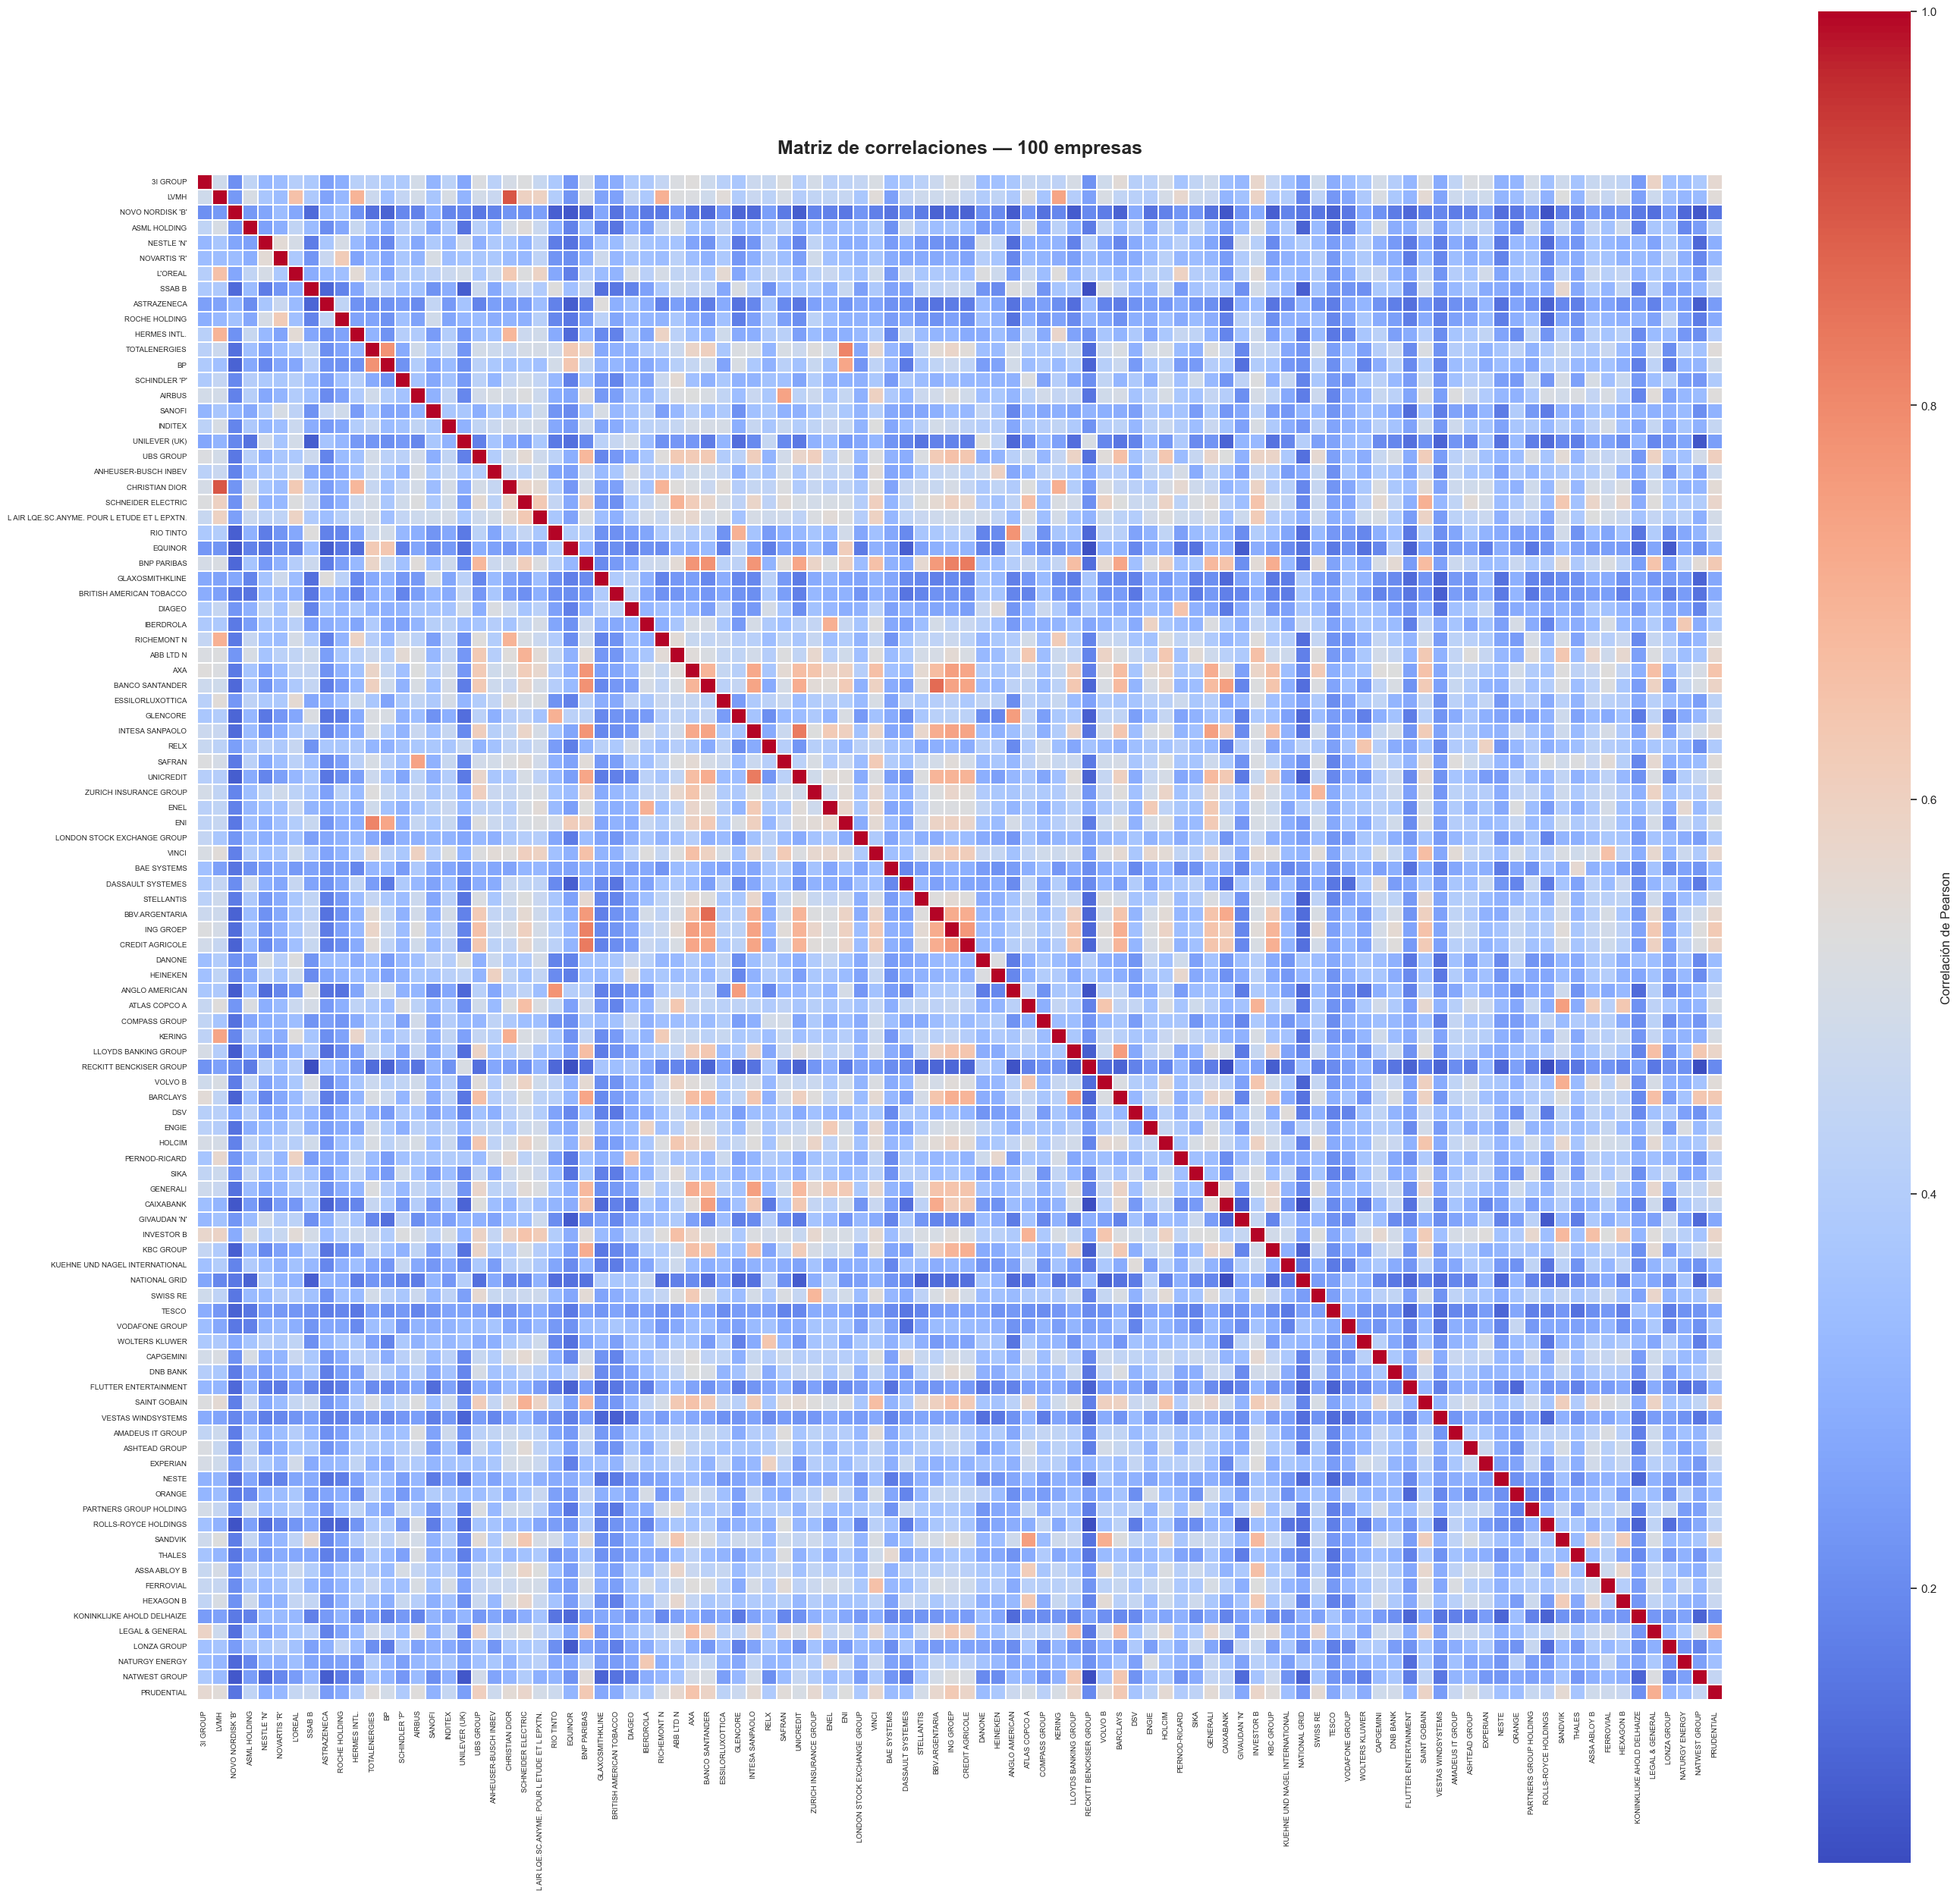

In [47]:
# Configuración de estilo
sns.set_theme(style="whitegrid", font_scale=1.0)
plt.rcParams["figure.dpi"] = 100   # alta resolución en pantalla
plt.rcParams["savefig.dpi"] = 100  # alta resolución al guardar

# Tamaño grande y proporcionado
fig, ax = plt.subplots(figsize=(28, 26))

# Mapa de calor
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    square=True,
    linewidths=0.2,     # líneas suaves entre celdas
    cbar_kws={'label': 'Correlación de Pearson'},
    xticklabels=True,
    yticklabels=True
)

# Ajustes visuales
plt.title("Matriz de correlaciones — 100 empresas", fontsize=18, weight='bold', pad=20)
plt.xticks(rotation=90, fontsize=7)
plt.yticks(rotation=0, fontsize=7)
plt.tight_layout()

# Mostrar
plt.show()

Miramos ratio entre desviaciones típicas de rendimientos

In [48]:
ratio = ret_df.std().max() / ret_df.std().min()
print("Ratio:", ratio)

Ratio: 2.9559262325797793


Como el ratio es mucho más grande que 2, usamos correlaciones. Esto tiene mucho sentido, ya que si las varianzas difieren en un factor tan grande, debemos estandarizar (usar correlaciones, dividir por desviaciones típicas) antes de hacer el análisis PCA.

---

### Componentes principales PCA
Caractericen los componentes principales necesarios para captar un porcentaje de las fluctuaciones del conjunto de rendimientos de los activos entre el 60% y el 70%. Traten de interpretar los tres primeros componentes principales en términos de las características de las empresas (tamaño, sector, riesgo beta, país, etc.).

  Componente  Varianza explicada (%)  Varianza acumulada (%)
0        PC1               37.629951               37.629951
1        PC2                5.980923               43.610874
2        PC3                4.029212               47.640086
3        PC4                2.573547               50.213633
4        PC5                2.307294               52.520927
5        PC6                1.941540               54.462468
6        PC7                1.580904               56.043372
7        PC8                1.444728               57.488100
8        PC9                1.266980               58.755080
9       PC10                1.228580               59.983660

Número de componentes = 100


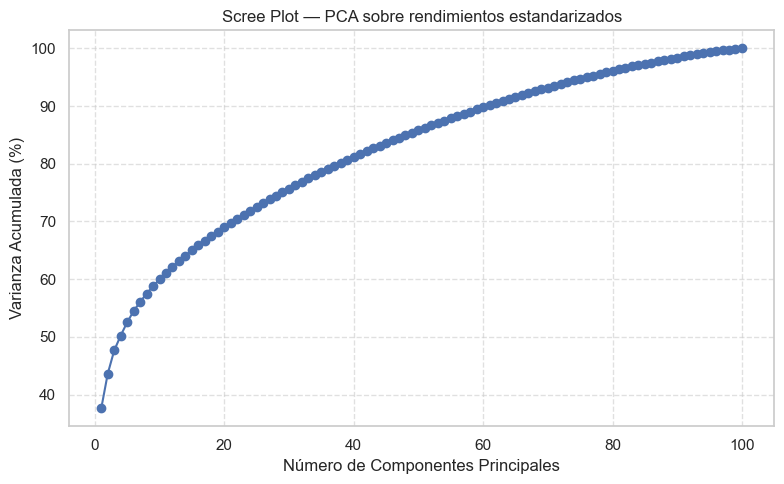

In [49]:
# 2. Estandarizar (centrar y escalar a varianza 1)
scaler = StandardScaler()
ret_std = scaler.fit_transform(ret_df)

# 3. Ajustar PCA sobre la matriz de correlaciones
pca = PCA()
pca.fit(ret_std)


# 4. Resumen de varianza explicada
pca_summary = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(pca.n_components_)],
    'Varianza explicada (%)': pca.explained_variance_ratio_ * 100,
    'Varianza acumulada (%)': np.cumsum(pca.explained_variance_ratio_) * 100
})

print(pca_summary.head(10))  # primeras 10 componentes
print(f"\nNúmero de componentes = {pca.n_components_}")

# 5. Gráfico de Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(
    range(1, pca.n_components_ + 1),
    np.cumsum(pca.explained_variance_ratio_) * 100,
    marker='o'
)
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada (%)')
plt.title('Scree Plot — PCA sobre rendimientos estandarizados')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [50]:
# Summary del PCA
pca_summary[pca_summary['Varianza acumulada (%)'].between(60, 70.2)]

,Componente,Varianza explicada (%),Varianza acumulada (%)
10,PC11,1.123254,61.106914
11,PC12,1.044303,62.151217
12,PC13,0.963890,63.115107
13,PC14,0.954024,64.069131
14,PC15,0.907528,64.976659
15,PC16,0.869143,65.845801
16,PC17,0.827964,66.673765
17,PC18,0.787512,67.461278
18,PC19,0.769127,68.230405
19,PC20,0.752752,68.983157


Necesitamos 21 PCA para explicar el 70% de la varianza total.

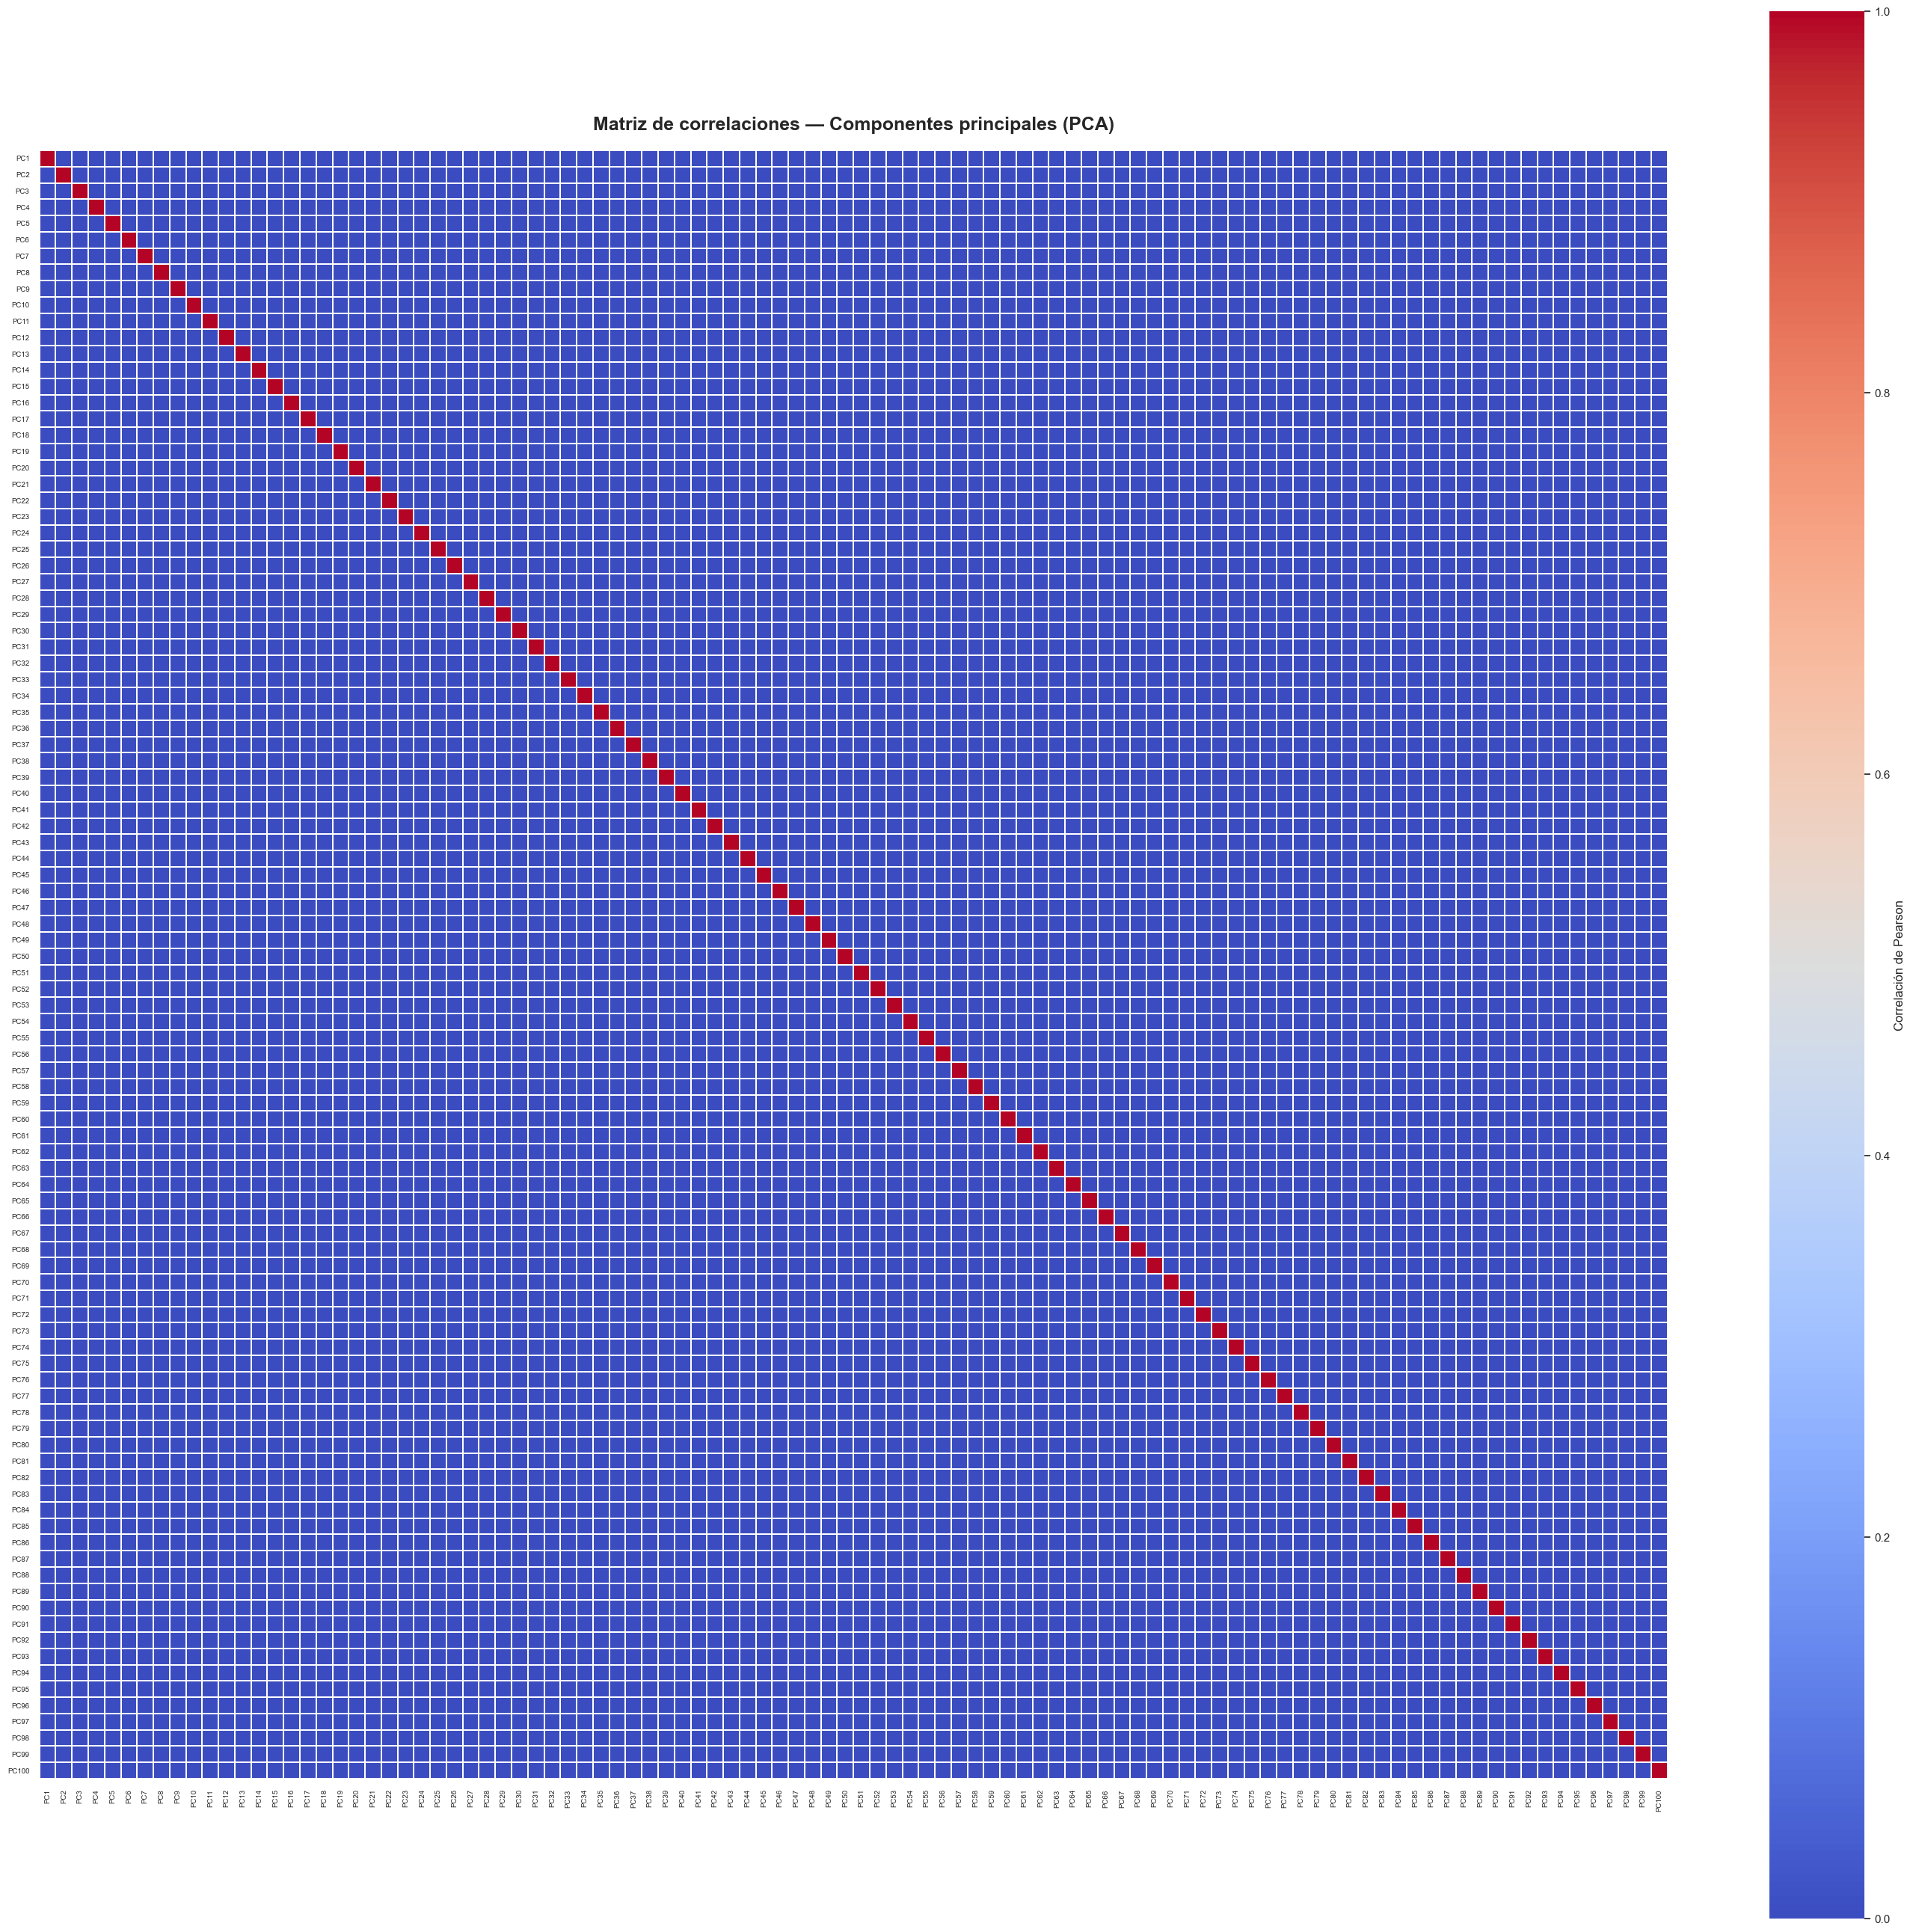

In [51]:
scores = pca.transform(ret_std)
scores_df = pd.DataFrame(
    scores,
    index=ret_df.index,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

# Matriz de correlaciones
corr_matrix = scores_df.corr()

sns.set_theme(style="whitegrid", font_scale=1.0)
plt.rcParams["figure.dpi"] = 100   
plt.rcParams["savefig.dpi"] = 100  

# Tamaño grande y proporcionado
fig, ax = plt.subplots(figsize=(28, 26))

# Mapa de calor
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    square=True,
    linewidths=0.2,     
    cbar_kws={'label': 'Correlación de Pearson'},
    xticklabels=True,
    yticklabels=True
)

plt.title("Matriz de correlaciones — Componentes principales (PCA)", fontsize=18, weight='bold', pad=20)
plt.xticks(rotation=90, fontsize=7)
plt.yticks(rotation=0, fontsize=7)
plt.tight_layout()

# Mostrar 
plt.show()


Correlaciones entre componentes y características

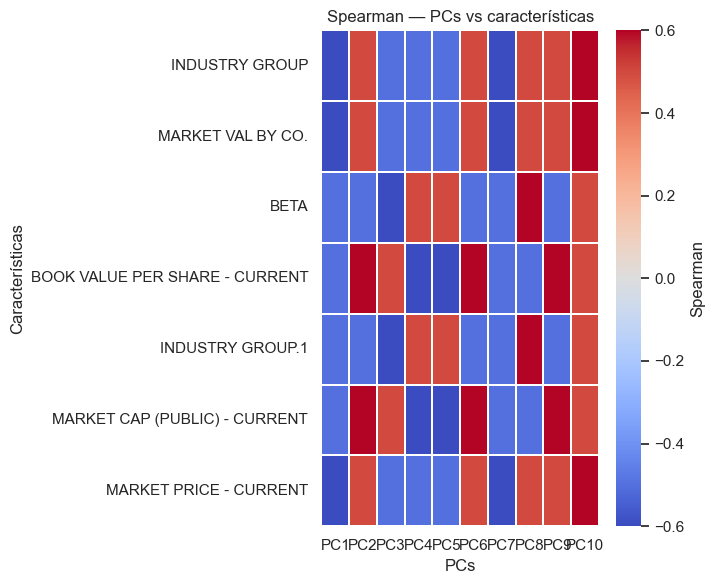

In [52]:
# 1) Cargar y fijar índice (nombre empresa)
carac = pd.read_excel("Clean_Data_100.xlsx", sheet_name="Carac")
name_col = next((c for c in ["COMPANY NAME","NAME"] if c in carac.columns), carac.columns[0])
carac = carac.set_index(name_col)

# 2) Normalizar nombres (coincidir con PCA)
norm = lambda s: (s.astype(str).str.upper()
                  .str.replace("['\",.,]", "", regex=True)
                  .str.replace(r"\s+", " ", regex=True).str.strip())
carac.index = norm(carac.index.to_series())
empresas = norm(pd.Series(ret_df.columns.astype(str)))

# 3) Matriz empresas×PCs y selección de PCs (>=80% var o top-10)
PCs = pd.DataFrame(pca.components_.T, index=empresas.values,
                   columns=[f"PC{i+1}" for i in range(pca.n_components_)])
common = PCs.index.intersection(carac.index)
PCs, carac = PCs.loc[common], carac.loc[common]

expl, K = pca.explained_variance_ratio_, min(10, np.searchsorted(np.cumsum(pca.explained_variance_ratio_), 0.80)+1)
PCs = PCs.iloc[:, :K]

X = carac.select_dtypes(include="number").copy()

# 5) Correlación Spearman entre DataFrames (X vs PCs)
corr = pd.DataFrame(index=X.columns, columns=PCs.columns, dtype=float)
for c in PCs:
    for v in X:
        m = X[v].notna() & PCs[c].notna()
        corr.loc[v, c] = spearmanr(X.loc[m, v], PCs.loc[m, c]).correlation if m.sum()>2 else np.nan

# 6) Heatmap
sns.set_theme(style="white")
plt.figure(figsize=(max(6, 0.7*corr.shape[1]), max(6, 0.25*corr.shape[0])))
sns.heatmap(corr, cmap="coolwarm", center=0, vmin=-0.6, vmax=0.6,
            cbar_kws={"label":"Spearman"}, linewidths=0.2)
plt.xlabel("PCs"); plt.ylabel("Características"); plt.title("Spearman — PCs vs características")
plt.tight_layout(); plt.show()


---

 ### Construcción carteras y análisis preliminar de las carteras (sin modelos factoriales)


Construimos las carteras asociadas a los 3 primeres componentes principales:

In [53]:
# Loadings de cada una de las tres primeras componentes principales
loadings = pd.DataFrame(
    pca.components_.T * ret_df.std().values,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=ret_df.columns
)

loadings_3 = loadings.iloc[:, :3]
print("\nLoadings de las primeras componentes:")
print(loadings_3.head(10))


Loadings de las primeras componentes:
                       PC1       PC2       PC3
3I GROUP          0.001936  0.000127 -0.000683
LVMH              0.002034  0.000975 -0.002120
NOVO NORDISK 'B'  0.000824  0.002099 -0.000231
ASML HOLDING      0.001619  0.000799 -0.003235
NESTLE 'N'        0.001381  0.003339  0.001359
NOVARTIS 'R'      0.001498  0.002388  0.001471
L'OREAL           0.001825  0.002420 -0.000207
SSAB B            0.001585 -0.001480 -0.001791
ASTRAZENECA       0.001065  0.002785  0.001815
ROCHE HOLDING     0.001325  0.002599  0.000908


In [54]:
#Construyo carteras_pca : F = X * W
carteras_pca = ret_df @ loadings_3

# Renombrar columnas
carteras_pca.columns = ['Cartera_PC1', 'Cartera_PC2', 'Cartera_PC3']

# Mostrar las primeras filas
print("\ncarteras_pca asociadas a los tres primeros componentes:")
print(carteras_pca.head())

# calcular varianzas explicadas relativas (para ver magnitudes)
varianzas = carteras_pca.var() / carteras_pca.var().sum() * 100
print("\nVarianza explicada por cada cartera (en % del total de las tres):")
print(varianzas)


carteras_pca asociadas a los tres primeros componentes:
            Cartera_PC1  Cartera_PC2  Cartera_PC3
Date                                             
2011-09-27     0.007864    -0.001716    -0.000250
2011-09-28    -0.001842     0.000207     0.000761
2011-09-29     0.001383    -0.001418     0.001259
2011-09-30    -0.003486     0.000568     0.001619
2011-10-03    -0.002494     0.001442     0.000081

Varianza explicada por cada cartera (en % del total de las tres):
Cartera_PC1    78.625494
Cartera_PC2    13.075735
Cartera_PC3     8.298770
dtype: float64


Construimos cartera equiponderada:

In [55]:
N = ret_df.shape[1]
cartera_Eq = (ret_df.fillna(0).sum(axis=1) / N).rename("Cartera_Eq")
print(cartera_Eq.head())

Date
2011-09-27    0.044486
2011-09-28   -0.010686
2011-09-29    0.007030
2011-09-30   -0.019328
2011-10-03   -0.013607
Name: Cartera_Eq, dtype: float64


Y ahora construyo las carteras con criterios de beta y tamaño:

In [56]:
# --- 1) Series numéricas 
beta = pd.to_numeric(caracT_df.loc["BETA"], errors="coerce")
size = pd.to_numeric(caracT_df.loc["MARKET CAP (PUBLIC) - CURRENT"], errors="coerce")
idx = ret_df.columns.intersection(beta.dropna().index).intersection(size.dropna().index)
ret = ret_df[idx]
beta = beta[idx]
size = size[idx]

# --- 3) Terciles estables con percentiles de rank
b_pct = beta.rank(method="first", pct=True)
s_pct = size.rank(method="first", pct=True)

b_bin = pd.cut(b_pct, [0, 1/3, 2/3, 1],
               labels=["LowBeta","MidBeta","HighBeta"], include_lowest=True)
s_bin = pd.cut(s_pct, [0, 1/3, 2/3, 1],
               labels=["Small","Medium","Big"], include_lowest=True)

# --- 4) Pesos long–short con net = 0 (NO se fuerza suma = 1)
asset_index = ret.columns

# Size: +1/nL a Small, -1/nS a Big
longs_size  = s_bin[s_bin == "Small"].index.intersection(asset_index)
shorts_size = s_bin[s_bin == "Big"].index.intersection(asset_index)

w_size = pd.Series(0.0, index=asset_index, dtype=float)
nL, nS = len(longs_size), len(shorts_size)
if nL > 0:
    w_size.loc[longs_size] =  1.0 / nL
if nS > 0:
    w_size.loc[shorts_size] = -1.0 / nS
# Nota: sum(w_size) = 1 - 1 = 0. No se normaliza L1.

# Beta: +1/nL a HighBeta, -1/nS a LowBeta
longs_beta  = b_bin[b_bin == "HighBeta"].index.intersection(asset_index)
shorts_beta = b_bin[b_bin == "LowBeta"].index.intersection(asset_index)

w_beta = pd.Series(0.0, index=asset_index, dtype=float)
nL_b, nS_b = len(longs_beta), len(shorts_beta)
if nL_b > 0:
    w_beta.loc[longs_beta] =  1.0 / nL_b
if nS_b > 0:
    w_beta.loc[shorts_beta] = -1.0 / nS_b

# Diagnóstico de pesos
print("Size  -> sum(w):", w_size.sum(), " | gross(L1):", w_size.abs().sum(),
      " | nL:", (w_size > 0).sum(), " | nS:", (w_size < 0).sum())
print("Beta  -> sum(w):", w_beta.sum(), " | gross(L1):", w_beta.abs().sum(),
      " | nL:", (w_beta > 0).sum(), " | nS:", (w_beta < 0).sum())

# --- 5) Construcción de carteras como combinación lineal de activos (ret @ w)
W = pd.DataFrame({"Cartera_Size": w_size, "Cartera_Beta": w_beta}, index=asset_index)
carteras = ret @ W

# --- 6) Resumen rápido
display(carteras.describe().T[["mean", "std"]])

# --- 7) Detectar empresas excluidas 
faltantes = ret_df.columns.difference(idx)
if len(faltantes) > 0:
    print(f"\nEmpresas excluidas por falta de BETA o SIZE ({len(faltantes)}):")
    for name in faltantes:
        motivo = []
        if pd.isna(beta.get(name, np.nan)): motivo.append("BETA")
        if pd.isna(size.get(name, np.nan)): motivo.append("SIZE")
        print(f" - {name}: falta {', '.join(motivo)}")
else:
    print("\nTodas las empresas tienen BETA y SIZE válidos.")


Size  -> sum(w): 0.0  | gross(L1): 2.0  | nL: 33  | nS: 34
Beta  -> sum(w): 1.3877787807814457e-17  | gross(L1): 1.9999999999999998  | nL: 34  | nS: 33


,mean,std
Cartera_Size,-0.000042,0.004565
Cartera_Beta,0.000128,0.007583



Todas las empresas tienen BETA y SIZE válidos.


Cartera de carteras...

In [57]:
carteras_total = pd.concat(
    [carteras_pca, carteras, cartera_Eq], 
    axis=1
)
print(carteras_total)

            Cartera_PC1  Cartera_PC2  Cartera_PC3  Cartera_Size  Cartera_Beta  \
Date                                                                            
2011-09-27     0.007864    -0.001716    -0.000250      0.002448      0.015491   
2011-09-28    -0.001842     0.000207     0.000761      0.000865     -0.005135   
2011-09-29     0.001383    -0.001418     0.001259      0.003566     -0.007428   
2011-09-30    -0.003486     0.000568     0.001619     -0.007122     -0.018267   
2011-10-03    -0.002494     0.001442     0.000081     -0.001854     -0.010782   
...                 ...          ...          ...           ...           ...   
2025-09-22    -0.000408    -0.000259    -0.000045      0.000789     -0.002111   
2025-09-23     0.000735    -0.000511    -0.000810     -0.001325      0.011965   
2025-09-24    -0.000633    -0.000614     0.001018      0.004961     -0.005383   
2025-09-25    -0.000807    -0.000214     0.000660      0.002222     -0.006611   
2025-09-26     0.001362    -

,Rentabilidad media,Desv. típica,Sharpe,Treynor,Sortino,Alfa Jensen
Cartera_Beta,0.000128,0.007583,0.016909,0.000050,0.024111,-0.000028
Cartera_Size,-0.000042,0.004565,-0.009143,-0.000059,-0.013176,-0.000085
Cartera_PC3,-0.000017,0.000592,-0.028496,0.000369,-0.043633,-0.000014
Cartera_PC2,0.000008,0.000743,0.010206,-0.000044,0.014442,0.000018
Cartera_PC1,0.000061,0.001823,0.033395,0.000061,0.041032,0.000000
Cartera_Eq,0.000357,0.010387,0.034378,0.000063,0.042225,0.000011


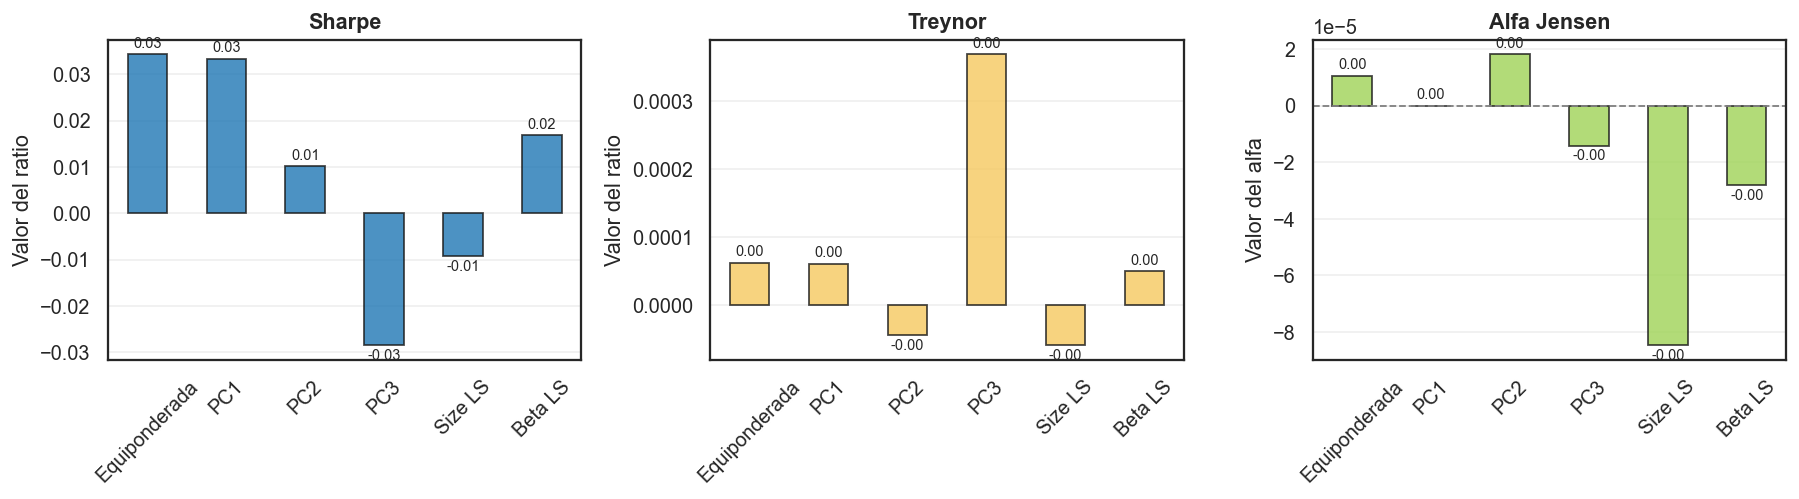

In [58]:
# --- 1) Datos ---
rf = 0  # rendimiento libre de riesgo
carteras_comp = carteras_total.copy()[[
    "Cartera_Beta", "Cartera_Size", "Cartera_PC3",
    "Cartera_PC2", "Cartera_PC1", "Cartera_Eq"
]]

# --- 2) Métricas ---
mean_ret = carteras_comp.mean()
std_ret  = carteras_comp.std()
cov_matrix = carteras_comp.cov()

# Betas respecto a PC1 como mercado
den_mkt = cov_matrix.loc["Cartera_PC1", "Cartera_PC1"]
beta_mkt = cov_matrix["Cartera_PC1"] / den_mkt if den_mkt != 0 else np.nan

# Downside deviation (solo rendimientos negativos)
downside_std = carteras_comp.apply(lambda x: x[x < 0].std(), axis=0)

# Evitar divisiones por cero
std_ret_safe       = std_ret.replace(0, np.nan)
downside_std_safe  = downside_std.replace(0, np.nan)
beta_mkt_safe      = beta_mkt.replace(0, np.nan)

# Ratios
sharpe = mean_ret / std_ret_safe
treynor = mean_ret / beta_mkt_safe
sortino = mean_ret / downside_std_safe
alpha_jensen = (mean_ret - rf) - beta_mkt_safe * (mean_ret["Cartera_PC1"] - rf)

# 3) Tabla resumen 
summary = pd.DataFrame({
    "Rentabilidad media": mean_ret,
    "Desv. típica": std_ret,
    "Sharpe": sharpe,
    "Treynor": treynor,
    "Sortino": sortino,
    "Alfa Jensen": alpha_jensen
}).round(8)

display(summary)

# 4) Etiquetas y orden del eje X 
display_order = ["Equiponderada", "PC1", "PC2", "PC3", "Size LS", "Beta LS"]
idx_map = {
    "Cartera_Eq":   "Equiponderada",
    "Cartera_PC1":  "PC1",
    "Cartera_PC2":  "PC2",
    "Cartera_PC3":  "PC3",
    "Cartera_Size": "Size LS",
    "Cartera_Beta": "Beta LS",
}

metricas_plot = summary.rename(index=idx_map)

faltan = [x for x in display_order if x not in metricas_plot.index]
if faltan:
    print("[INFO] Faltan en summary:", faltan)

metricas_plot = metricas_plot.reindex(display_order)

# 5) Plot en 1x3 subplots, mismo estilo 
cols  = ['Sharpe', 'Treynor', 'Alfa Jensen']
cmap  = ['#1f77b4', '#f6c85f', '#9fd356']
ylabs = ['Valor del ratio', 'Valor del ratio', 'Valor del alfa']

fig, axes = plt.subplots(1, 3, figsize=(14, 4), dpi=130)

for ax, col, color, ylabel in zip(axes, cols, cmap, ylabs):
    s = metricas_plot[col]
    s.plot.bar(ax=ax, color=color, edgecolor='k', alpha=0.8)

    ax.set_title(col, fontweight='bold')
    ax.set_xlabel("")
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

    # Línea base solo para el alfa
    if col == 'Alfa Jensen':
        ax.axhline(0, ls='--', color='gray', lw=1)

    # Etiquetas numéricas encima
    for cont in ax.containers:
        ax.bar_label(cont, fmt="%.2f", fontsize=8, padding=2)

plt.tight_layout()
plt.show()


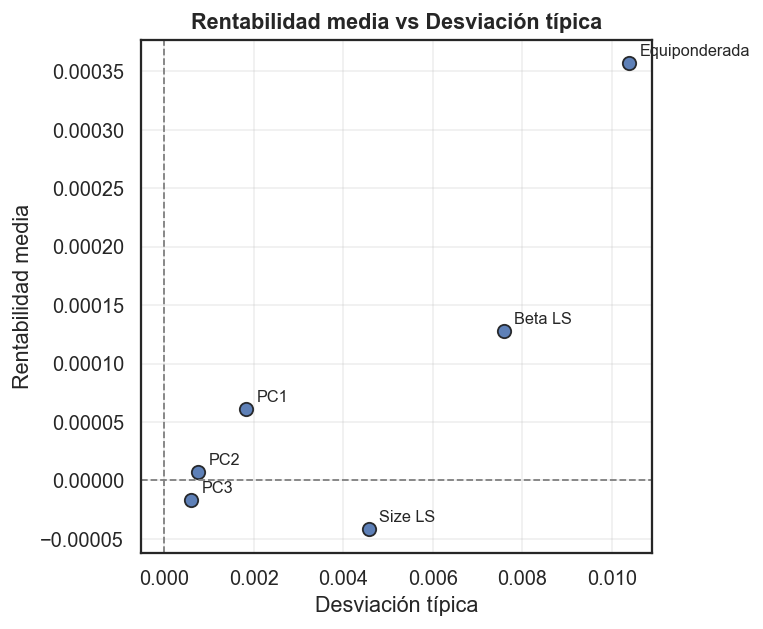

In [59]:
# === 6) Scatter: Rentabilidad media vs Desv. típica ===
fig, ax = plt.subplots(figsize=(6, 5), dpi=130)

# Datos (en el orden humano definido)
x = metricas_plot["Desv. típica"]
y = metricas_plot["Rentabilidad media"]

# Puntos
ax.scatter(x, y, s=55, edgecolor='k', alpha=0.9)
for lbl, x0, y0 in zip(metricas_plot.index, x.values, y.values):
    ax.annotate(lbl, (x0, y0), xytext=(6, 4), textcoords='offset points', fontsize=9)

# Ejes y rejilla
ax.set_xlabel("Desviación típica")
ax.set_ylabel("Rentabilidad media")
ax.set_title("Rentabilidad media vs Desviación típica", fontweight='bold')
ax.grid(alpha=0.3)

# Línea base (eje x=0 / y=0)
ax.axhline(0, ls='--', color='gray', lw=1)
ax.axvline(0, ls='--', color='gray', lw=1)

plt.tight_layout()
plt.show()

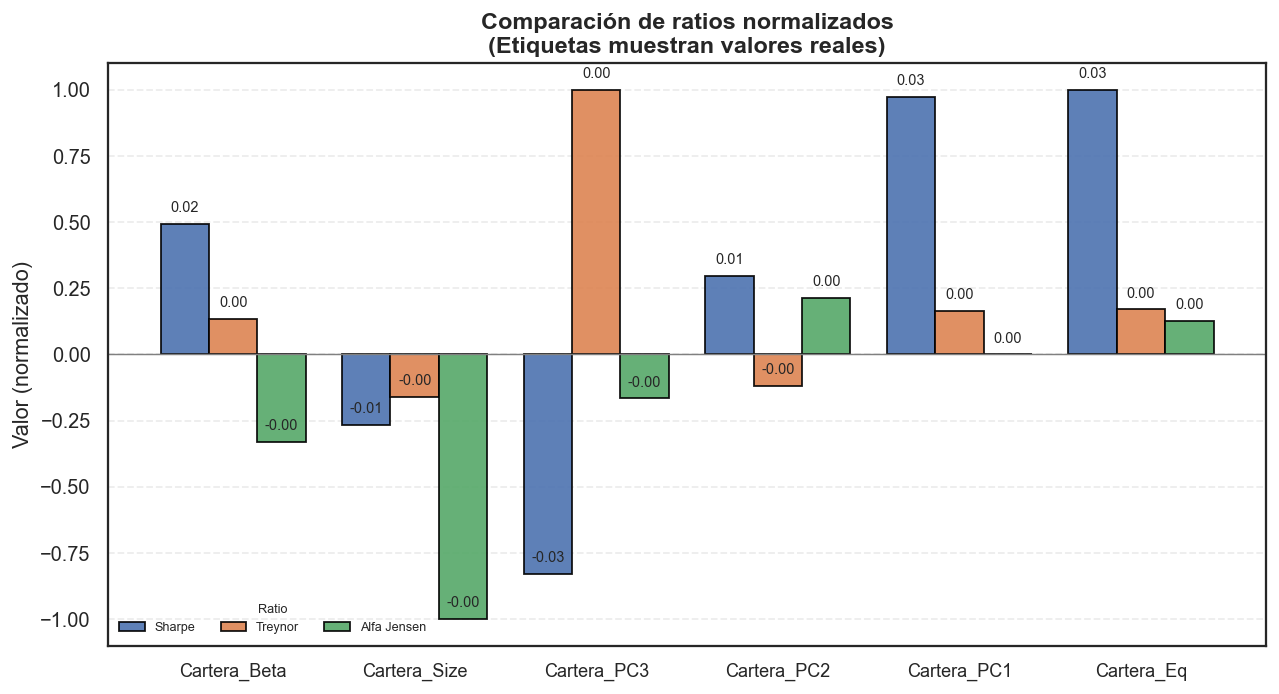

In [60]:
# --- Preparar ratios (si no existen, los calculamos) ---
# Comprueba/usa columnas ya disponibles en summary
ratios = pd.DataFrame(index=summary.index)

# Sharpe y Treynor vienen de summary en tu código previo
if "Sharpe" in summary.columns:
    ratios["Sharpe"] = summary["Sharpe"]
if "Treynor" in summary.columns:
    ratios["Treynor"] = summary["Treynor"]
if "Alfa Jensen" in summary.columns:
    ratios["Alfa Jensen"] = summary["Alfa Jensen"]
else:
    # beta_mkt y mean_ret deben existir (los calculaste antes)
    alpha_jensen = (mean_ret - rf) - beta_mkt * (mean_ret["Cartera_PC1"] - rf)
    ratios["Alfa Jensen"] = alpha_jensen

# Asegurarnos del orden de las columnas
cols = ["Sharpe", "Treynor", "Alfa Jensen"]
cols = [c for c in cols if c in ratios.columns]
ratios = ratios[cols]

# --- Normalizar para visualización (hace que todas se vean bien juntas) ---
# Guardamos los valores originales para etiquetado
ratios_orig = ratios.copy()

# Normalización por el máximo absoluto de cada columna (mantiene signo)
ratios_plot = ratios.divide(ratios.abs().max())

# --- Gráfico de barras agrupadas ---
n = len(ratios_plot)                 # número de carteras
m = len(ratios_plot.columns)         # número de ratios
ind = np.arange(n)
width = 0.8 / m                       # ancho de barra por ratio

fig, ax = plt.subplots(figsize=(10, 5.5), dpi=130)

# paleta simple (cambia si quieres otros colores)
palette = ["#4C72B0", "#55A868", "#DD8452"]

for i, col in enumerate(ratios_plot.columns):
    positions = ind - 0.4 + i * width + width/2
    bars = ax.bar(positions, ratios_plot[col].values, width=width,
                  label=col, edgecolor="black", alpha=0.9)
    # Etiquetas encima: mostramos el valor real (no normalizado)
    for bar, real_val in zip(bars, ratios_orig[col].values):
        height = bar.get_height()
        ax.annotate(f"{real_val:.2f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5), textcoords="offset points",
                    ha="center", va="bottom", fontsize=8, rotation=0)

# Ajustes estéticos
ax.set_xticks(ind)
ax.set_xticklabels(ratios_plot.index, rotation=0, fontsize=10)
ax.set_title("Comparación de ratios normalizados\n(Etiquetas muestran valores reales)", fontsize=13, fontweight="bold")
ax.set_ylabel("Valor (normalizado)")
ax.grid(alpha=0.35, axis="y", linestyle="--")
ax.axhline(0, color="grey", linewidth=0.8)

ax.legend(title="Ratio", ncol=m, fontsize=7, title_fontsize=7, loc="lower left")
plt.tight_layout()
plt.show()


In [61]:
# Selecciona las columnas relevantes
cols_factores = ["Cartera_Eq", "Cartera_Size", "Cartera_Beta"]
cols_pca = ["Cartera_PC1", "Cartera_PC2", "Cartera_PC3"]
missing_cols = [c for c in cols_factores + cols_pca if c not in carteras_total.columns]

if missing_cols:
    print(f"⚠️ Faltan columnas en carteras_total: {missing_cols}")
else:
    # Calculamos matriz de correlaciones cruzadas
    corrs = carteras_total[cols_factores + cols_pca].corr().loc[cols_factores, cols_pca]
    
    print("\n📈 Correlaciones entre carteras económicas y factores PCA:")
    display(corrs.style.background_gradient(cmap="coolwarm", axis=None).format("{:.2f}"))
    print("\n📈 Correlaciones entre carteras económicas y factores PCA -en valor absoluto-:")
    display(np.abs(corrs).style.background_gradient(cmap="coolwarm", axis=None).format("{:.2f}"))


📈 Correlaciones entre carteras económicas y factores PCA:


,Cartera_PC1,Cartera_PC2,Cartera_PC3
Cartera_Eq,1.00,-0.39,-0.14
Cartera_Size,0.28,-0.61,0.21
Cartera_Beta,0.62,-0.62,-0.59



📈 Correlaciones entre carteras económicas y factores PCA -en valor absoluto-:


,Cartera_PC1,Cartera_PC2,Cartera_PC3
Cartera_Eq,1.00,0.39,0.14
Cartera_Size,0.28,0.61,0.21
Cartera_Beta,0.62,0.62,0.59


La tabla de correlaciones muestra que las carteras Size y Beta guardan una relación moderadamente fuerte con las componentes principales PC2 y PC3, aunque con signo negativo. Esto indica que los factores estadísticos extraídos mediante el PCA capturan patrones económicos consistentes: PC2 refleja principalmente una combinación entre tamaño y riesgo sistemático —donde empresas más pequeñas y con betas bajas tienden a moverse en sentido opuesto a las grandes y de mayor riesgo—, mientras que PC3 se asocia de forma más directa con el factor beta, representando diferencias en sensibilidad al mercado. En conjunto, las componentes PC2 y PC3 recogen dimensiones de riesgo complementarias al factor de mercado (PC1).

---

### Modelo factorial con PCA's

In [62]:
scores_3 = pca.transform(ret_std)[:, :3]                  # (n, 3)
factors_df = pd.DataFrame(scores_3, index=ret_df.index, columns=["PC1","PC2","PC3"])

X = np.column_stack([np.ones(len(ret_df)), scores_3])     # (n, 1+3)
Y = ret_df.values                                         # (n, m)


resultados = ajusta_modelo(X, Y)

# Betas por activo (filas=PC1..PC3, cols=activos)
betas_df = pd.DataFrame(resultados["beta"], 
                        index=["PC1","PC2","PC3"], 
                        columns=ret_df.columns)

desvTip = pd.Series(resultados["desvTip"], index=ret_df.columns, name="desvTip")
AIC      = pd.Series(resultados["AIC"],      index=ret_df.columns, name="AIC")


print("Betas (sin constante):")
display(betas_df)

print("\nDesviaciones típicas residuales (σ̂_j):")
display(desvTip.to_frame().T)

print("\nAIC por activo:")
display(AIC.to_frame().T)

Betas (sin constante):


,3I GROUP,LVMH,NOVO NORDISK 'B',ASML HOLDING,NESTLE 'N',NOVARTIS 'R',L'OREAL,SSAB B,ASTRAZENECA,ROCHE HOLDING,...,THALES,ASSA ABLOY B,FERROVIAL,HEXAGON B,KONINKLIJKE AHOLD DELHAIZE,LEGAL & GENERAL,LONZA GROUP,NATURGY ENERGY,NATWEST GROUP,PRUDENTIAL
PC1,0.001936,0.002006,0.000875,0.001889,0.000786,0.000996,0.001463,0.002198,0.000903,0.000928,...,0.001353,0.001639,0.001633,0.001924,0.000813,0.002183,0.001409,0.001367,0.002314,0.002439
PC2,0.000129,0.000975,0.002259,0.000945,0.001928,0.001609,0.001967,-0.002080,0.002396,0.001845,...,-0.000048,0.000832,0.000082,0.000666,0.001189,-0.001561,0.002097,0.000014,-0.003660,-0.001248
PC3,-0.000643,-0.001969,-0.000231,-0.003556,0.000729,0.000921,-0.000156,-0.002339,0.001450,0.000599,...,0.000814,-0.001537,0.000696,-0.003060,0.001401,0.000293,-0.001772,0.002207,0.000529,-0.000507



Desviaciones típicas residuales (σ̂_j):


,3I GROUP,LVMH,NOVO NORDISK 'B',ASML HOLDING,NESTLE 'N',NOVARTIS 'R',L'OREAL,SSAB B,ASTRAZENECA,ROCHE HOLDING,...,THALES,ASSA ABLOY B,FERROVIAL,HEXAGON B,KONINKLIJKE AHOLD DELHAIZE,LEGAL & GENERAL,LONZA GROUP,NATURGY ENERGY,NATWEST GROUP,PRUDENTIAL
desvTip,0.012202,0.010539,0.016417,0.014385,0.006857,0.008528,0.009152,0.018201,0.011687,0.009429,...,0.013721,0.010129,0.010703,0.012531,0.010875,0.011839,0.014158,0.011885,0.021282,0.012617



AIC por activo:


,3I GROUP,LVMH,NOVO NORDISK 'B',ASML HOLDING,NESTLE 'N',NOVARTIS 'R',L'OREAL,SSAB B,ASTRAZENECA,ROCHE HOLDING,...,THALES,ASSA ABLOY B,FERROVIAL,HEXAGON B,KONINKLIJKE AHOLD DELHAIZE,LEGAL & GENERAL,LONZA GROUP,NATURGY ENERGY,NATWEST GROUP,PRUDENTIAL
AIC,-32196.362904,-33267.024312,-30027.667799,-30993.286264,-36407.612447,-34814.602862,-34297.846033,-29273.843935,-32511.492382,-34080.288701,...,-31338.831255,-33557.137453,-33154.124762,-32001.739666,-33037.791879,-32416.621514,-31109.390376,-32388.629074,-28131.11306,-31951.662413


In [63]:
B = betas_df.T.values
N = B.shape[0]
factor_names = list(factors_df.columns)  # ["PC1","PC2","PC3"]

Sigma_f = np.asarray(factors_df.cov().values)
Sigma_f = 0.5 * (Sigma_f + Sigma_f.T)

if isinstance(desvTip, (pd.Series, pd.DataFrame)):
    d_vec = np.asarray(desvTip).reshape(-1,)
else:
    d_vec = np.asarray(desvTip).reshape(-1,)

if isinstance(desvTip, pd.Series):
    if not all(desvTip.index == ret_df.columns):
        d_vec = desvTip.reindex(ret_df.columns).values

d_vec = np.where(d_vec < 0, 0.0, d_vec)
D = np.diag(d_vec)

Sigma = B @ Sigma_f @ B.T + D
Sigma = 0.5 * (Sigma + Sigma.T)

In [64]:
w_eq = np.repeat(1.0 / N, N)                                      

asset_index = ret_df.columns  
small_idx = s_bin[s_bin == "Small"].index.intersection(asset_index)
big_idx   = s_bin[s_bin == "Big"].index.intersection(asset_index)

w_size = np.zeros(N, dtype=float)
if len(small_idx) > 0:
    w_size_pd = pd.Series(0.0, index=asset_index)
    w_size_pd.loc[small_idx] = 1.0
    w_size_pd.loc[big_idx]   = -1.0
    w_size_pd = w_size_pd / w_size_pd.abs().sum()
    w_size = w_size_pd.reindex(betas_df.columns).fillna(0.0).values

high_idx = b_bin[b_bin == "HighBeta"].index.intersection(asset_index)
low_idx  = b_bin[b_bin == "LowBeta"].index.intersection(asset_index)

w_beta = np.zeros(N, dtype=float)
if len(high_idx) > 0:
    w_beta_pd = pd.Series(0.0, index=asset_index)
    w_beta_pd.loc[high_idx] = 1.0
    w_beta_pd.loc[low_idx]  = -1.0
    w_beta_pd = w_beta_pd / w_beta_pd.abs().sum()
    w_beta = w_beta_pd.reindex(betas_df.columns).fillna(0.0).values

res_eq   = analiza_cartera_w(w_eq,   B, Sigma_f, d_vec, Sigma, asset_index=betas_df.columns)
res_size = analiza_cartera_w(w_size, B, Sigma_f, d_vec, Sigma, asset_index=betas_df.columns)
res_beta = analiza_cartera_w(w_beta, B, Sigma_f, d_vec, Sigma, asset_index=betas_df.columns)

In [65]:
rows = []
for name, r in [("Cartera Equiponderada", res_eq),
                ("Cartera Size", res_size),
                ("Cartera Beta", res_beta)]:
    
    if name == "Cartera Equiponderada":
        AIC = calcular_aic_cartera(res_eq["w"], factors_df, ret_df)
    elif name == "Cartera Size":
        AIC = calcular_aic_cartera(res_size["w"], factors_df, ret_df)
    elif name == "Cartera Beta":
        AIC = calcular_aic_cartera(res_beta["w"], factors_df, ret_df)
    
    rows.append({
        "Cartera": name,
        "Riesgo Total (var. total)": r["var_total"],
        "Riesgo Sist.": r["var_sist"],
        "Riesgo Idio.": r["var_idio"],
        "% Riesgo Sist.": to_pct(r["pct_sist"]),
        "% Riesgo Idio.": to_pct(r["pct_idio"]),
        "AIC": AIC  
        })

res_table = pd.DataFrame(rows).set_index("Cartera")

# Mostrar con formato legible
display(res_table.round({
    "Riesgo Total (var. total)": 8,
    "Riesgo Sist.": 8,
    "Riesgo Idio.": 8,
    "% Riesgo Sist.": 2,
    "% Riesgo Idio.": 2,
    "AIC": 2
}))


,Riesgo Total (var. total),Riesgo Sist.,Riesgo Idio.,% Riesgo Sist.,% Riesgo Idio.,AIC
Cartera,,,,,,
Cartera Equiponderada,0.000230,0.000108,0.000122,46.78,53.22,-45747.65
Cartera Size,0.000184,0.000002,0.000182,1.03,98.97,-35892.99
Cartera Beta,0.000198,0.000013,0.000185,6.66,93.34,-37800.74


,Sharpe,Treynor,Alpha_Jensen
Cartera,,,
Equiponderada,0.034378,0.034412,0.000357
Size LS,-0.011697,-0.019131,-0.000026
Beta LS,0.017865,0.019095,0.000069


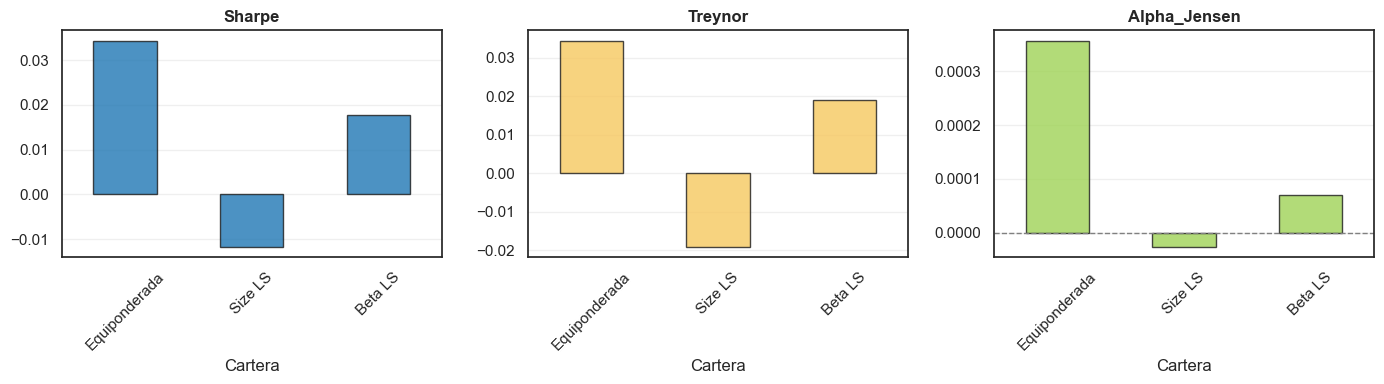

In [66]:
F = factors_df.copy()
Omega = Sigma_f.copy()

r_eq   = ret_df.dot(res_eq['w'])
r_size = ret_df.dot(res_size['w'])
r_beta = ret_df.dot(res_beta['w'])

carteras_analizar = [
    ('Equiponderada', r_eq),
    ('Size LS', r_size),
    ('Beta LS', r_beta)
]

metricas = []
for nombre, r in carteras_analizar:
    beta, e, model = estimar_beta(r, F)

    idx = F.index.intersection(r.index)
    rhat = F.loc[idx].values @ beta
    sigma_sys = np.sqrt(beta @ Omega @ beta)
    
    # --- Ratios de performance ---
    sharpe = r.mean() / r.std(ddof=1)
    treynor = r.mean() / sigma_sys
    alpha = r.mean() - np.mean(rhat)

    metricas.append({
        'Cartera': nombre,
        'Sharpe': sharpe,
        'Treynor': treynor,
        'Alpha_Jensen': alpha
    })

metricas_df = pd.DataFrame(metricas).set_index('Cartera')
display(metricas_df.round(6))

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, col, color in zip(
    axes, 
    ['Sharpe', 'Treynor', 'Alpha_Jensen'], 
    ['#1f77b4', '#f6c85f', '#9fd356']
):
    metricas_df[col].plot.bar(ax=ax, color=color, edgecolor='k', alpha=0.8)
    ax.set_title(col, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    if col == 'Alpha_Jensen':
        ax.axhline(0, ls='--', color='gray', lw=1)

plt.tight_layout()
plt.show()


---

### Modelo Barra


Creamos matriz de dummys (betas del modelo BARRA)

In [67]:
carac_df = carac_df.loc[:, ~carac_df.columns.duplicated()]

carac_df1 = pd.DataFrame({
    'country':    carac_df['COUNTRY OF DOMICIL'].astype('category'),
    'beta_class': carac_df['dum_BETA'].astype('category'),
    'book_class': carac_df['dum_book'].astype('category'),
    'size_class': carac_df['dum_SIZE'].astype('category'),
})

refs = {
    'country':    carac_df1['country'].cat.categories[0],
    'beta_class': carac_df1['beta_class'].cat.categories[0],
    'book_class': carac_df1['book_class'].cat.categories[0],
    'size_class': carac_df1['size_class'].cat.categories[0],
}

# --- 2) Dummies con referencia (drop_first=True) para garantizar rango completo ---
X_country = pd.get_dummies(carac_df1['country'],    prefix='country', drop_first=True, dtype=int)
X_beta    = pd.get_dummies(carac_df1['beta_class'], prefix='beta',    drop_first=True, dtype=int)
X_book    = pd.get_dummies(carac_df1['book_class'], prefix='book',    drop_first=True, dtype=int)
X_size    = pd.get_dummies(carac_df1['size_class'], prefix='size',    drop_first=True, dtype=int)

# --- 3) Matriz de exposiciones B ---
B = pd.concat([X_country, X_beta, X_book, X_size], axis=1)

# Limpieza por si hubiera columnas vacías (no deberían, pero por seguridad)
B = B.loc[:, (B != 0).any(axis=0)]

# Comprobación de rango 
rank_B = np.linalg.matrix_rank(B.values)
if rank_B < B.shape[1]:
    B = B.drop(columns=[B.columns[0]])
    rank_B = np.linalg.matrix_rank(B.values)

print("Dimensión B:", B.shape, "| Rango:", rank_B)
print("Categorías de referencia (excluidas):", refs)

Dimensión B: (100, 23) | Rango: 23
Categorías de referencia (excluidas): {'country': 'BG', 'beta_class': 'agr', 'book_class': 'big', 'size_class': 'LargeCap'}


In [68]:
resultado = ajusta_barra_mcg(B, ret_df)

Miramos matriz de correlaciones entre factores ajustados

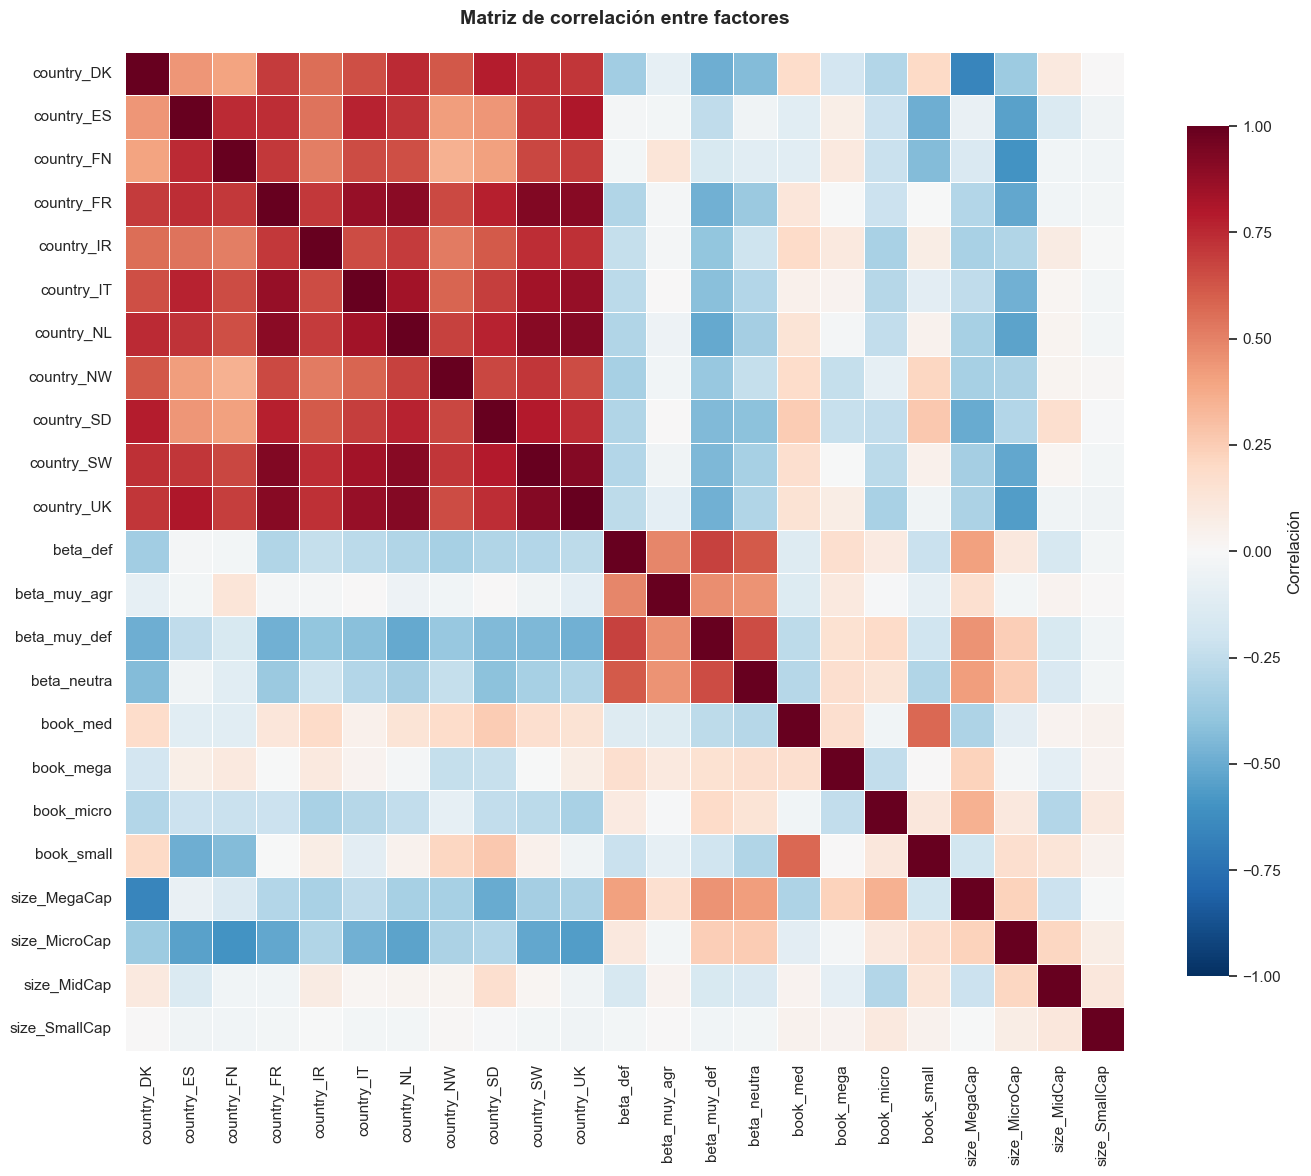

In [69]:
# Matriz de correlación de factores
F = resultado['factores']
corr_factores = F.corr()

# Heatmap
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(
    corr_factores,
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Correlación', 'shrink': 0.8},
    ax=ax
)
ax.set_title('Matriz de correlación entre factores', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

Para la cartera equiponderada:

In [70]:
# Equiponderada
w_eq = np.ones(100) / 100
resultados_eq = analiza_cartera_barra(w_eq, B, ret_df, resultado, 'Equiponderada')

Para las carteras de los tres primeros componentes principales

In [71]:
# Carteras PCA (normalizar loadings)
loadings_3 = loadings.iloc[:, :3]

resultados_pca = {}
for i in range(3):
    w = loadings_3.iloc[:, i].abs()
    w = w / w.sum()
    resultados_pca[f'PC{i+1}'] = analiza_cartera_barra(
        w.values, B, ret_df, resultado, f'PC{i+1}'
    )

resumen_pca = pd.concat([r['resumen'] for r in resultados_pca.values()])

Para las carteras size y beta

In [72]:
# Preparar datos
beta = pd.to_numeric(caracT_df.loc["BETA"], errors="coerce")
size = pd.to_numeric(caracT_df.loc["MARKET CAP (PUBLIC) - CURRENT"], errors="coerce")

idx = ret_df.columns.intersection(beta.dropna().index).intersection(size.dropna().index)
beta, size = beta[idx], size[idx]

# Terciles
b_pct = beta.rank(pct=True)
s_pct = size.rank(pct=True)

b_bin = pd.cut(b_pct, [0, 1/3, 2/3, 1], labels=["Low","Mid","High"])
s_bin = pd.cut(s_pct, [0, 1/3, 2/3, 1], labels=["Small","Mid","Big"])

# Pesos
w_size = pesos_longshort(s_bin[s_bin == "Small"].index,
                         s_bin[s_bin == "Big"].index,
                         ret_df.columns)

w_beta = pesos_longshort(b_bin[b_bin == "High"].index,
                         b_bin[b_bin == "Low"].index,
                         ret_df.columns)

# Analizar
resultados_size = analiza_cartera_barra(w_size.values, B, ret_df, resultado, 'Size_LS', longshort=True)
resultados_beta = analiza_cartera_barra(w_beta.values, B, ret_df, resultado, 'Beta_LS', longshort=True)


Resumen descomposición de varianza

In [73]:
# Todos los resultados
resumen_total = pd.concat([
    resultados_eq['resumen'],
    resumen_pca,
    resultados_size['resumen'],
    resultados_beta['resumen']
])

display(resumen_total)

# Top factores
for nombre, res in [('Eq', resultados_eq), ('PC1', resultados_pca['PC1']), 
                     ('Size', resultados_size), ('Beta', resultados_beta)]:
    print(f"\n{nombre}:")
    print(res['contrib'].nlargest(5, 'pct_rc')[['factor', 'pct_rc']].to_string(index=False))




,var_total,var_sist,var_idio,pct_sist,pct_idio,T,net_exp,AIC
Equiponderada,0.000108,0.000104,3.953414e-06,96.335815,3.664185,3654,1.000000e+00,-51206.403350
PC1,0.000119,0.000105,1.378456e-05,88.368834,11.631166,3654,1.000000e+00,-48567.709851
PC2,0.000105,0.000104,8.703382e-07,99.168101,0.831899,3654,1.000000e+00,-47979.008271
PC3,0.000098,0.000102,0.000000e+00,104.161858,0.000000,3654,1.000000e+00,-50412.937115
Size_LS,0.000021,0.000007,1.370020e-05,34.246093,65.753907,3654,0.000000e+00,-40125.614905
Beta_LS,0.000057,0.000002,5.544530e-05,3.570689,96.429311,3654,1.387779e-17,-37078.870081



Eq:
    factor    pct_rc
country_UK 23.090244
country_FR 21.685588
country_SW 15.393496
country_NL  8.466423
country_SD  7.273427

PC1:
    factor    pct_rc
country_FR 22.030842
country_UK 21.703281
country_SW 15.224019
country_NL  9.841932
country_SD  6.622946

Size:
    factor    pct_rc
book_small 77.003318
country_UK 24.465077
country_ES  9.916951
country_IT  3.526819
country_SD  2.765346

Beta:
       factor    pct_rc
   book_small 46.188965
   country_IR 18.513503
size_MicroCap 13.917047
   country_FR 13.661688
   country_IT  8.047667


Resumen valor medio temporal de los factores

In [74]:
factores_medias = resultado['factores'].mean().to_frame(name='Media temporal')
display(factores_medias.round(6))

,Media temporal
country_DK,0.000331
country_ES,0.000268
country_FN,0.000353
country_FR,0.000454
country_IR,0.000777
country_IT,0.000415
country_NL,0.000265
country_NW,0.000285
country_SD,0.000391
country_SW,0.000331


Gráfico para visualizar

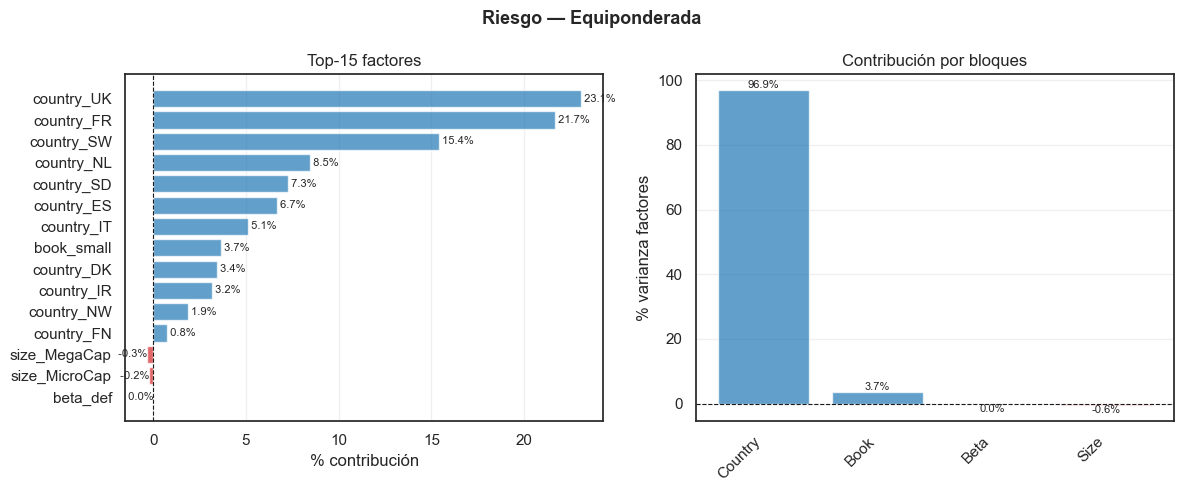

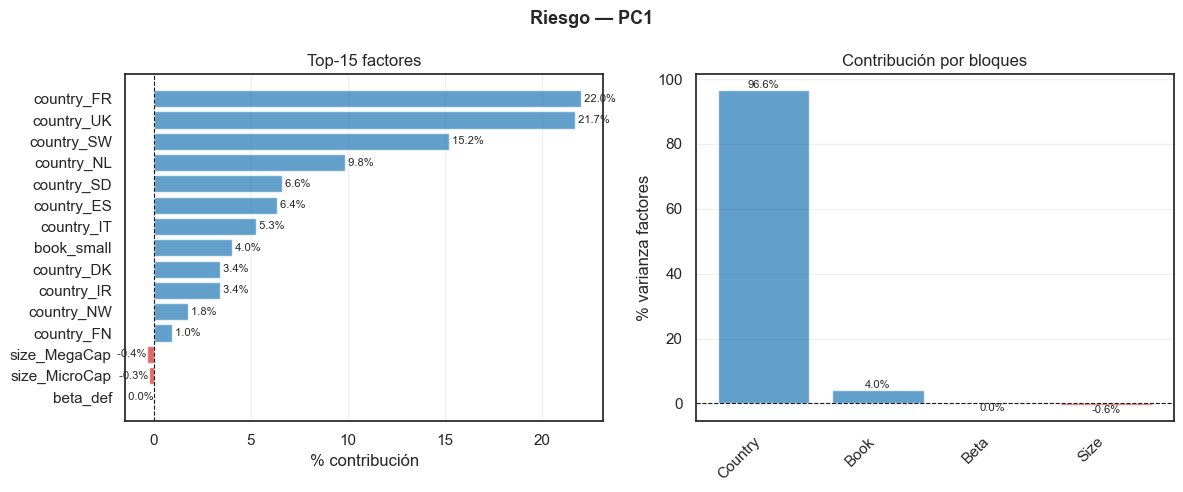

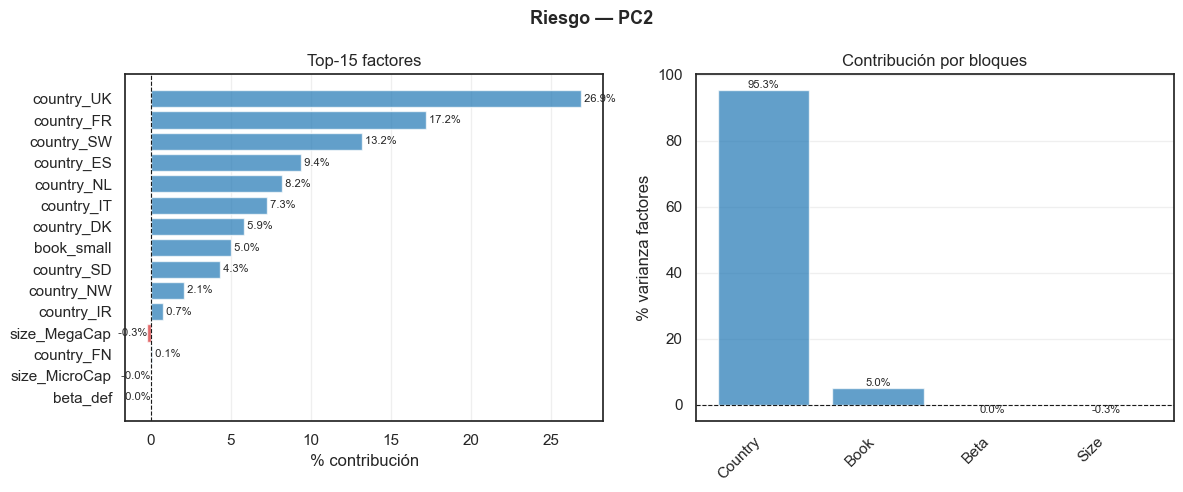

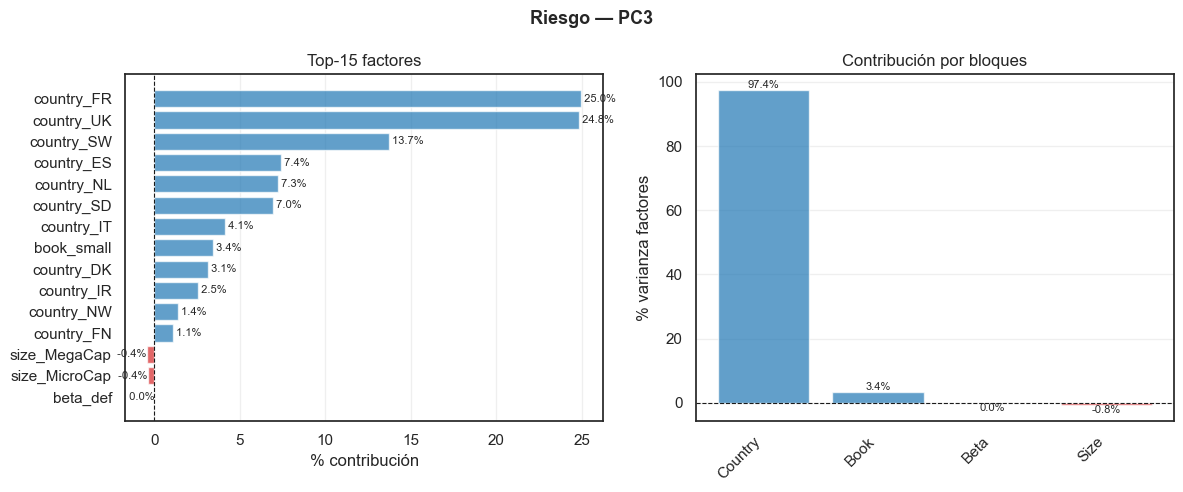

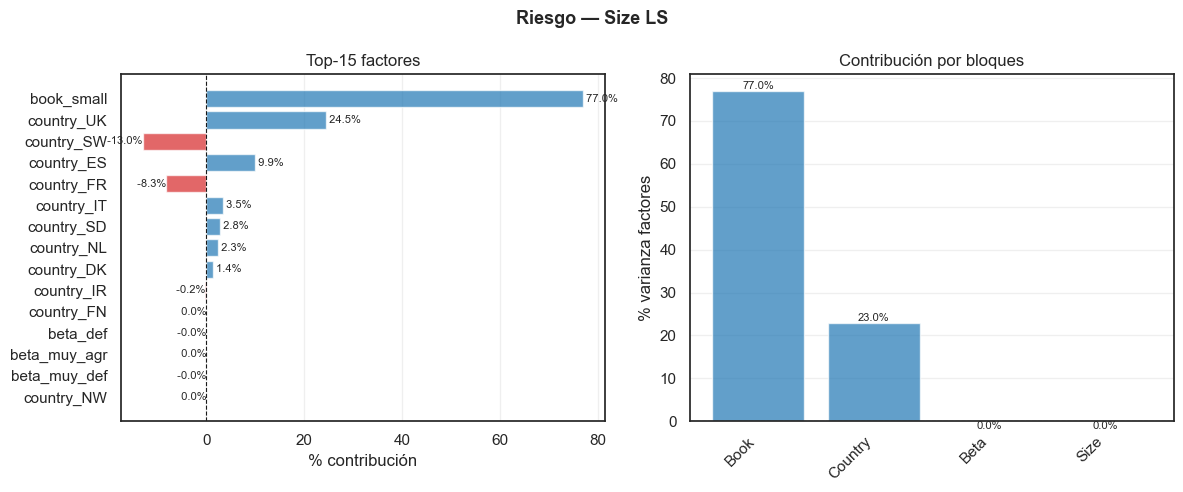

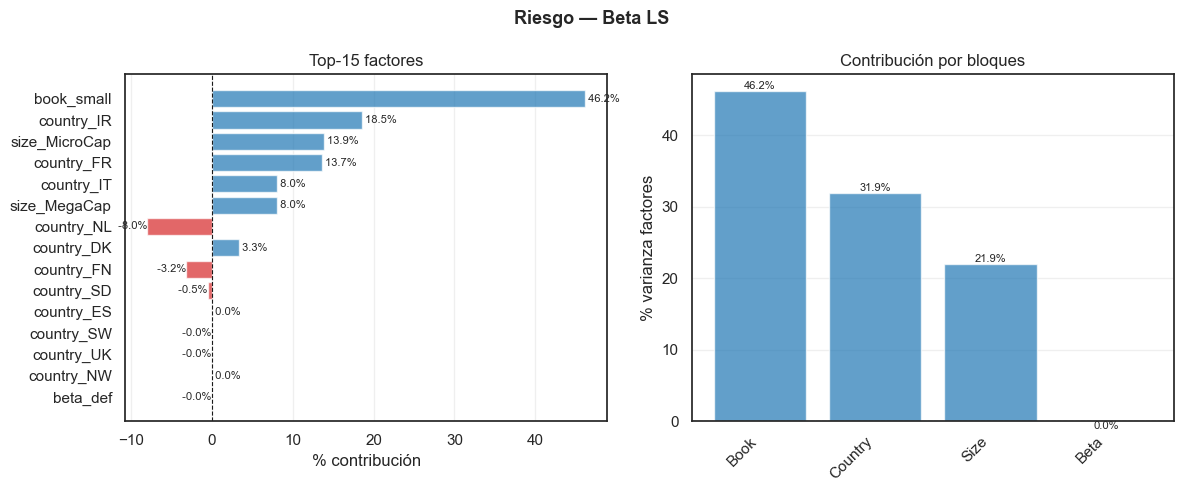

In [75]:
for nombre, res in [('Equiponderada', resultados_eq), 
                     ('PC1', resultados_pca['PC1']),
                     ('PC2', resultados_pca['PC2']),
                     ('PC3', resultados_pca['PC3']),
                     ('Size LS', resultados_size),
                     ('Beta LS', resultados_beta)]:
    grafico_contrib(res, nombre, top_k=15)

Correlaciones entre factores

,Sharpe,Treynor,Alpha
Cartera,,,
Equiponderada,0.035616,0.034470,0.000005
PC1,0.035449,0.034548,0.000010
PC2,0.033953,0.032321,-0.000011
PC3,0.036142,0.034390,-0.000008
Size LS,0.012002,0.009762,-0.000068
Beta LS,0.013793,0.020580,0.000099


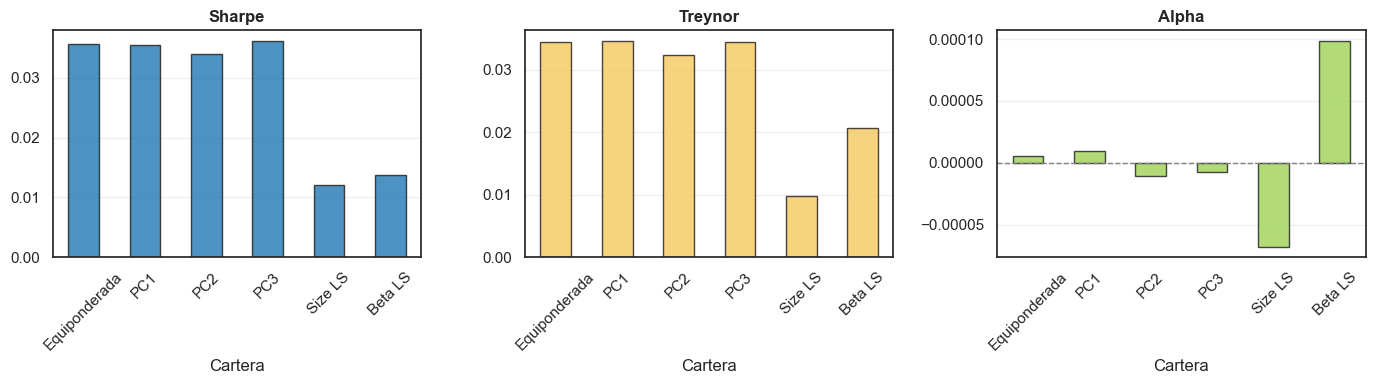

In [76]:
# Calcular métricas directamente
F = resultado['factores']
Omega = resultado['Omega_f'].values

# Calcular para todas las carteras
carteras_analizar = [
    ('Equiponderada', resultados_eq),
    ('PC1', resultados_pca['PC1']),
    ('PC2', resultados_pca['PC2']),
    ('PC3', resultados_pca['PC3']),
    ('Size LS', resultados_size),
    ('Beta LS', resultados_beta)
]

metricas = []
for nombre, res in carteras_analizar:
    beta = res['betas'].values.ravel()
    e = res['residuos']
    
    idx = F.index.intersection(e.index)
    X = F.loc[idx].values
    rhat = X @ beta
    r = rhat + e.loc[idx].values
    
    sigma_sys = np.sqrt(beta @ Omega @ beta)
    
    metricas.append({
        'Cartera': nombre,
        'Sharpe': rhat.mean() / rhat.std(ddof=1),
        'Treynor': rhat.mean() / sigma_sys,
        'Alpha': r.mean() - rhat.mean()
    })

metricas_df = pd.DataFrame(metricas).set_index('Cartera')
display(metricas_df.round(10))

# Plot
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, col, color in zip(axes, ['Sharpe','Treynor','Alpha'], 
                          ['#1f77b4','#f6c85f','#9fd356']):
    metricas_df[col].plot.bar(ax=ax, color=color, edgecolor='k', alpha=0.8)
    ax.set_title(col, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    if col == 'Alpha': ax.axhline(0, ls='--', color='gray', lw=1)

plt.tight_layout()
plt.show()